In [1]:
pip install torch datasets

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torch.nn as nn
import pandas as pd
import json
from torch.utils.data import Dataset, DataLoader, random_split
import re
from sklearn.utils import shuffle

In [3]:
def get_data(filename):
    
    with open(filename, 'r', encoding='utf-8') as file:
        data = json.load(file)

    df = pd.DataFrame(data)
    return df

data = get_data('output_file copy.json')
# data = get_data('./rnn/only_action_method/output_file copy.json')

data.head()

,content_syntactic_blocstring,action_blocstring,changes_list_content_syntactic_,changes_list_action,src,userId,user_class,tweet_count,change_content_syntactic,change_action,change_change_dynamic_score,highest_change_in_content_syntactic,lowest_change_in_content_syntactic,standard_deviation_of_content_syntactic,highest_change_in_action,lowest_change_in_action,standard_deviation_of_action,diversity_action,diversity_content_syntactic,diversity_change_dynamics_score
0,(mmmmmmmmqt)(mmmmmmmmqt)(mmmmmmmmqt)(mmmmmmmmq...,rprp⚀pr□prrprrrprpprprprprprpprprprp□rprprprrr...,"[0.683772233983162, 0.00647286670992131, 0.801...","{'content_syntactic': [0.683772233983162, 0.00...",astroturf,146048090,bot,274,0.556376,0.297313,1.024345,0.938307,0.006473,0.275047,0.901294,0.054951,0.200933,0.653102,0.652532,0.450906
1,(mmmmmmmqt)(mmmmmmmqt)(mmmmmmmqt)(mmmmmmmqt)(m...,r□pr□rr□rp⚀r⚀TTTTTTT□r⚀p⚀π□p|⚀rr⚀rr⚀rr□r⚀r|⚀p⚀...,"[0.0600874600144512, 0.022936062507937005, 0.0...","{'content_syntactic': [0.0600874600144512, 0.0...",astroturf,797927149856403456,bot,275,0.427565,0.484909,0.711994,1.000000,0.004220,0.356787,0.989180,0.068479,0.291316,0.707387,0.693840,0.151417
2,(mmt)(mmt)(qt)(qt)(qt)(mqt)(qt)(t)(qt)(qt)(Em)...,r□r⚀r⚀rr□rrr□r□r⚀rrr⚀r|⚁rrrrr□rrrrrr□rpprrrp□r...,"[0.4050577935998917, 0.2173762078750736, 0.181...","{'content_syntactic': [0.4050577935998917, 0.2...",astroturf,1046169889138868225,bot,277,0.442671,0.284123,1.405920,1.000000,0.015253,0.265496,0.913974,0.045573,0.204972,0.676182,0.644029,0.297367
3,(mmt)(mmmmmmqt)(mmmmmmmmmqt)(mmt)(mmt)(qt)(mmm...,prrpp□rrrrrrrrrrrrrr□rr□rrr□rrprrrrrrr□prrrrrr...,"[0.6288092648051271, 0.17944110183186945, 1.0,...","{'content_syntactic': [0.6288092648051271, 0.1...",astroturf,1085010463128195073,bot,244,0.368786,0.419595,1.029069,1.000000,0.111362,0.206134,1.000000,0.049906,0.306818,0.698081,0.620676,0.211830
4,(mmmmmmmqt)|(Em)|(t)(mmqt)(mt)(mmt)|(qt)(HUqt)...,p|⚁p|⚀p□p□p□p|⚁rrrrrrrrpr□prrprr□rrrprrprrrprp...,"[1.0, 1.0, 0.7298648986655512, 0.8616571072267...","{'content_syntactic': [1.0, 1.0, 0.72986489866...",astroturf,1613166488,bot,245,0.618332,0.353069,0.605766,1.000000,0.209196,0.253005,0.849471,0.075654,0.199506,0.680286,0.766445,0.627025


In [4]:
print("Original class distribution:")
print(data['user_class'].value_counts())

# Separate data by user_class
bots = data[data['user_class'] == 'bot']
humans = data[data['user_class'] == 'human']

# Select the minimum class size
min_class_size = min(len(bots), len(humans))

# Downsample each class to the minimum class size
bots_balanced = bots.sample(n=min_class_size, random_state=1)
humans_balanced = humans.sample(n=min_class_size, random_state=1)

# Combine the balanced classes
balanced_data = pd.concat([bots_balanced, humans_balanced])

# Shuffle the data
balanced_data = shuffle(balanced_data, random_state=1).reset_index(drop=True)

print("Balanced class distribution:")
print(balanced_data['user_class'].value_counts())

data = balanced_data

Original class distribution:
user_class
bot      32041
human    27704
Name: count, dtype: int64
Balanced class distribution:
user_class
human    27704
bot      27704
Name: count, dtype: int64


In [5]:
import numpy as np
np.unique(data['src'])

array(['astroturf', 'botometer-feedback-19', 'botwiki-19', 'celebrity-19',
       'cresci-17', 'cresci-rtbust-19', 'cresci-stock-18', 'gilani-17',
       'midterm-18', 'political-bots-19', 'pronbots-19', 'varol-17',
       'vendor-purchased-19', 'verified-19'], dtype=object)

In [6]:
print("data shape", data.shape)
print("columns", data.columns)

data shape (55408, 20)
columns Index(['content_syntactic_blocstring', 'action_blocstring',
       'changes_list_content_syntactic_', 'changes_list_action', 'src',
       'userId', 'user_class', 'tweet_count', 'change_content_syntactic',
       'change_action', 'change_change_dynamic_score',
       'highest_change_in_content_syntactic',
       'lowest_change_in_content_syntactic',
       'standard_deviation_of_content_syntactic', 'highest_change_in_action',
       'lowest_change_in_action', 'standard_deviation_of_action',
       'diversity_action', 'diversity_content_syntactic',
       'diversity_change_dynamics_score'],
      dtype='object')


In [7]:
class UserDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        text = self.data.loc[idx, 'action_blocstring'][:200]
        label = 1 if self.data.loc[idx, 'user_class'] == 'bot' else 0
        return {
            'text': text, 
            'label': label 
        }

dataset = UserDataset(data)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Example usage: Iterate through the test loader
# for batch in val_loader:
#     print(batch['text'], batch['label'])


In [8]:
# Counter: subclass of Python's dictionary used for counting hashable objects, in this case, tokens (words).
# OrderedDict: subclass of Python's dictionary that remembers the insertion order of keys. It is used to store tokens in a specific order based on frequency.
from collections import Counter, OrderedDict
# re: A module for working with regular expressions, used to manipulate and clean text.
import re

# Token counts and vocab creation
# Initializes an empty Counter object to hold the frequency of each token in the dataset.
token_counts = Counter()

# Define tokenizer
def tokenizer(text):

    #  replace | with " "
    # text = text.replace("|", " ")

    return list(text)

# Tokenize the training data and populate token_counts
for entry in train_dataset:  # Assuming train_dataset is a dataset with 'text'
    line = entry['text']
    tokens = tokenizer(line)
    token_counts.update(tokens)

# Sort tokens by frequency
# token_counts.items() returns the tokens and their respective counts as a list of tuples (e.g., [(token1, count1), (token2, count2), ...])
# key=lambda x: x[1] means that the sorting is based on the count (x[1]), which is the second element of each tuple
# reverse=True means that the most frequent tokens appear first in the sorted list.
sorted_by_freq_tuples = sorted(token_counts.items(), key=lambda x: x[1], reverse=True)

# Create an ordered dictionary for the vocab
ordered_dict = OrderedDict(sorted_by_freq_tuples)

# The padding token (pad) is used to ensure that all sequences in a batch have the same length.
# The unknown token (unk) is used to represent words that are not found in the model's vocabulary (the top 69021 words in your case).
# Any word that doesn't appear in the vocabulary is replaced by the unk token during tokenization.
# This is critical for handling unseen words during inference, where the model encounters words that were not present in the training data.
# Create vocab dictionary with special tokens
# Initializes the vocab dictionary with two special tokens
vocab = {"<pad>": 0, "<unk>": 1}

for idx, (token, count) in enumerate(ordered_dict.items(), start=2):  # Start from 2 to skip the special tokens
    vocab[token] = idx


# Print the vocabulary size (should be 69023)
print('Vocab-size:', len(vocab))
print('vocab', vocab)
# --- Rationale:
#
# By assigning frequent words lower indices, we can optimize memory and computational efficiency.
# Words that appear infrequently can either be assigned higher indices (in case we want to keep them) or omitted from the vocabulary entirely.

Vocab-size: 15
vocab {'<pad>': 0, '<unk>': 1, '|': 2, 'r': 3, 'T': 4, '⚁': 5, '⚀': 6, '□': 7, 'p': 8, '⚂': 9, '⚃': 10, 'π': 11, '⚄': 12, 'ρ': 13, '⚅': 14}


In [9]:
# action T|⚂T|⚅T□TT□r⚀r⚀r|⚀r|⚀r□r⚀r|⚂rTT□r□r⚀r□r|⚀r⚀r⚀r

# content (t)|(t)|(Et)(E)(Et)(qt)(Et)(EHUt)|(Et)|(mUt)(HHHHHHt)(qt)|(qt)(E)(Et)(mmmqt)(Et)(HUt)(Ut)|(qt)(mqt)(EHUt)

# text (T -> t)|(⚂)(T -> t)|(⚅)(T -> Et)(□)(T -> E)(T -> Et)(□)(r -> qt)(⚀)(r -> Et)(⚀)(r -> EHUt)|(⚀)(r -> Et)|(⚀)(r -> mUt)(□)

def encode(tokens):
    #If the token does not exist in the vocab, the function returns the index of the <unk>
    return [vocab.get(token, vocab["<unk>"]) for token in tokens]
# Example usage
print(encode(tokenizer('(T -> t)|(⚂)(T -> t)|(⚅)(T -> Et)(□)(T -> E)(T -> Et)(□)(r -> qt)(⚀)(r -> Et)(⚀)(r -> EHUt)|(⚀)(r -> Et)|(⚀)(r -> mUt)(□)')))  # Should output something like [11, 7, 35, 457]

[1, 4, 1, 1, 1, 1, 1, 1, 2, 1, 9, 1, 1, 4, 1, 1, 1, 1, 1, 1, 2, 1, 14, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 7, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 7, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 6, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 2, 1, 6, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7, 1]


In [10]:
if not torch.cuda.is_available():
    print("Warning: this code may be very slow on CPU")

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Use the manual vocab creation process from earlier
# Assuming `vocab` and `tokenizer` are already defined

#text_pipeline = lambda x: [vocab[token] for token in tokenizer(x)]
# Updated text pipeline
text_pipeline = lambda x: [vocab.get(token, vocab["<unk>"]) for token in tokenizer(x)]

label_pipeline = lambda x: float(x)  # Convert to float to match the output

# Batch collation function
def collate_batch(batch):
    label_list, text_list, lengths = [], [], []
    for entry in batch:  # Each 'entry' is a dictionary with 'text' and 'label'
        _label = entry['label']
        _text = entry['text']

        # Process labels and text
        label_list.append(label_pipeline(_label))  # Convert labels using label_pipeline
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)  # Convert text to indices

        # Store processed text and its length
        text_list.append(processed_text)
        lengths.append(processed_text.size(0))

    # Convert lists to tensors and pad sequences
    label_list = torch.tensor(label_list)
    lengths = torch.tensor(lengths)
    padded_text_list = nn.utils.rnn.pad_sequence(text_list, batch_first=True)

    return padded_text_list.to(device), label_list.to(device), lengths.to(device)

In [12]:
#-----  Example usage with DataLoader -----#
## Take a small batch

dataloader = DataLoader(train_dataset, batch_size=4, shuffle=False, collate_fn=collate_batch)
text_batch, label_batch, length_batch = next(iter(dataloader))

# Print the output batch
print("Text batch:", text_batch)
print("Label batch:", label_batch)
print("Length batch:", length_batch)
print("Text batch shape:", text_batch.shape)

Text batch: tensor([[ 4,  6,  4,  2,  5,  4,  2,  5,  4,  2,  5,  4,  2,  5,  4,  2,  5,  4,
          7,  4,  2,  9,  4,  7,  4,  2,  5,  4,  2,  6,  4,  6,  4,  2,  5,  4,
          2,  5,  4,  2,  5,  4,  2,  5,  4,  7,  4,  2,  9,  4,  2, 10,  4,  2,
          5,  4,  2,  5,  4,  2,  9,  4,  2,  5,  4,  2,  5,  4,  2,  5,  4,  2,
          5,  4,  6,  4,  2,  5,  4,  2,  5,  4,  6,  4,  2,  5,  4,  2,  5,  4,
          6,  4,  2,  5,  4,  2,  5,  4,  7,  4,  2,  5,  4,  2,  5,  4,  2,  5,
          4,  2,  5,  4,  2,  5,  4,  6,  4,  2,  5,  4,  2,  5,  4,  2,  5,  4,
          2,  5,  4,  2,  6,  4,  2,  9,  4,  2,  9,  4,  2,  6,  4,  7,  4,  6,
          4,  2,  9,  4,  2,  5,  4,  2,  5,  4,  2,  5,  4,  2,  5,  4,  2,  5,
          4,  2,  5,  4,  2,  5,  4,  2,  5,  4,  2,  5,  4,  2,  6,  4,  6,  4,
          2,  5,  4,  2,  5,  4,  2,  5,  4,  2,  5,  4,  6,  4,  7,  4,  2,  5,
          4,  2],
        [ 4,  4,  7,  4,  7,  4,  6,  3,  3,  3,  6,  3,  7,  3,  6,  3,  2,  6

In [13]:
## Batching the datasets
batch_size = 32
vocab_size = len(vocab)

train_dl = DataLoader(train_dataset, batch_size=batch_size,
                      shuffle=True, collate_fn=collate_batch)
val_dl = DataLoader(val_dataset, batch_size=batch_size,
                      shuffle=False, collate_fn=collate_batch)
test_dl = DataLoader(test_dataset, batch_size=batch_size,
                     shuffle=False, collate_fn=collate_batch)

In [14]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size, num_layers=2, dropout_rate=0.5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.rnn = nn.LSTM(embed_dim, rnn_hidden_size, num_layers=num_layers, 
                           batch_first=True, dropout=dropout_rate)  # Add num_layers and dropout between layers
        self.dropout = nn.Dropout(dropout_rate)  # Explicit dropout layer
        self.fc1 = nn.Linear(rnn_hidden_size, fc_hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(fc_hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, text, lengths):
        # Embedding Layer
        out = self.embedding(text)
        
        # Pack the padded sequence
        out = nn.utils.rnn.pack_padded_sequence(out, lengths.cpu().numpy(), 
                                                enforce_sorted=False, batch_first=True)
        
        # LSTM Layers
        out, (hidden, cell) = self.rnn(out)
        
        # Take the hidden state of the last layer
        out = hidden[-1, :, :]  # Shape: (batch_size, rnn_hidden_size)
        
        # Fully Connected Layers
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)  # Dropout for FC layer
        out = self.fc2(out)
        out = self.sigmoid(out)
        
        return out

In [15]:
def train_epoch(dataloader, model, optimizer, loss_fn):
    model.train()
    total_acc, total_loss = 0, 0
    for text_batch, label_batch, lengths in dataloader:  # Loop through batches in dataloader
        optimizer.zero_grad()
        pred = model(text_batch, lengths)[:, 0]
        loss = loss_fn(pred, label_batch)
        loss.backward()
        optimizer.step()
        total_acc += ((pred >= 0.5).float() == label_batch).float().sum().item()
        total_loss += loss.item() * label_batch.size(0)
    return total_acc / len(dataloader.dataset), total_loss / len(dataloader.dataset)

def evaluate_epoch(dataloader, model, loss_fn):
    model.eval()
    total_acc, total_loss = 0, 0
    with torch.no_grad():
        for text_batch, label_batch, lengths in dataloader:  # Loop through batches in dataloader
            pred = model(text_batch, lengths)[:, 0]
            loss = loss_fn(pred, label_batch)
            total_acc += ((pred >= 0.5).float() == label_batch).float().sum().item()
            total_loss += loss.item() * label_batch.size(0)
    return total_acc / len(dataloader.dataset), total_loss / len(dataloader.dataset)

In [16]:
# Grid search for hyperparameter tuning
import itertools

# Hyperparameter ranges
param_grid = {
    'lr': [0.001, 0.0001],
    'embed_dim': [16, 32, 64],
    'rnn_hidden_size': [32, 64, 128],
    'fc_hidden_size': [32, 64, 128],
    'num_layers': [1, 2, 3],  # Add num_layers
    'dropout_rate': [0, 0.3, 0.5]  # Add dropout_rate
}

# Generate all combinations of hyperparameters
param_combinations = list(itertools.product(
    param_grid['lr'],
    param_grid['embed_dim'],
    param_grid['rnn_hidden_size'],
    param_grid['fc_hidden_size'],
    param_grid['num_layers'],
    param_grid['dropout_rate']
))

# Track results
results = []

# Grid search loop
for lr, embed_dim, rnn_hidden_size, fc_hidden_size, num_layers, dropout_rate in param_combinations:
    print(f"Testing with lr={lr}, embed_dim={embed_dim}, rnn_hidden_size={rnn_hidden_size}, "
          f"fc_hidden_size={fc_hidden_size}, num_layers={num_layers}, dropout_rate={dropout_rate}")
    
    # Initialize model and optimizer for current hyperparameters
    model = RNN(vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size, 
                num_layers=num_layers, dropout_rate=dropout_rate).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.BCELoss()

    # Train and evaluate for a few epochs (to save time during grid search)
    for epoch in range(5):  # Shortened training for grid search
        train_epoch(train_dl, model, optimizer, loss_fn)

    acc_valid, _ = evaluate_epoch(val_dl, model, loss_fn)

    print({
        'lr': lr,
        'embed_dim': embed_dim,
        'rnn_hidden_size': rnn_hidden_size,
        'fc_hidden_size': fc_hidden_size,
        'num_layers': num_layers,
        'dropout_rate': dropout_rate,
        'val_accuracy': acc_valid
    })
    # Store results
    results.append({
        'lr': lr,
        'embed_dim': embed_dim,
        'rnn_hidden_size': rnn_hidden_size,
        'fc_hidden_size': fc_hidden_size,
        'num_layers': num_layers,
        'dropout_rate': dropout_rate,
        'val_accuracy': acc_valid
    })

# Convert results to DataFrame for easier analysis
import pandas as pd
results_df = pd.DataFrame(results)

# Find the best hyperparameter combination
best_params = results_df.loc[results_df['val_accuracy'].idxmax()]

print("Best hyperparameters:")
print(best_params)

# Save the results for future reference
results_df.to_csv('grid_search_results.csv', index=False)


Testing with lr=0.001, embed_dim=16, rnn_hidden_size=32, fc_hidden_size=32, num_layers=1, dropout_rate=0


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 32, 'fc_hidden_size': 32, 'num_layers': 1, 'dropout_rate': 0, 'val_accuracy': 0.8347972566478161}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=32, fc_hidden_size=32, num_layers=1, dropout_rate=0.3


/sciclone/data10/iahewababarand/.venv/lib64/python3.9/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 32, 'fc_hidden_size': 32, 'num_layers': 1, 'dropout_rate': 0.3, 'val_accuracy': 0.8559740103477319}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=32, fc_hidden_size=32, num_layers=1, dropout_rate=0.5


/sciclone/data10/iahewababarand/.venv/lib64/python3.9/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 32, 'fc_hidden_size': 32, 'num_layers': 1, 'dropout_rate': 0.5, 'val_accuracy': 0.8760678618698111}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=32, fc_hidden_size=32, num_layers=2, dropout_rate=0


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 32, 'fc_hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0, 'val_accuracy': 0.8475514378534472}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=32, fc_hidden_size=32, num_layers=2, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 32, 'fc_hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0.3, 'val_accuracy': 0.8035134159547588}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=32, fc_hidden_size=32, num_layers=2, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 32, 'fc_hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0.5, 'val_accuracy': 0.8662014198050776}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=32, fc_hidden_size=32, num_layers=3, dropout_rate=0


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 32, 'fc_hidden_size': 32, 'num_layers': 3, 'dropout_rate': 0, 'val_accuracy': 0.8726988328720973}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=32, fc_hidden_size=32, num_layers=3, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 32, 'fc_hidden_size': 32, 'num_layers': 3, 'dropout_rate': 0.3, 'val_accuracy': 0.8213211406569606}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=32, fc_hidden_size=32, num_layers=3, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 32, 'fc_hidden_size': 32, 'num_layers': 3, 'dropout_rate': 0.5, 'val_accuracy': 0.8548911081698953}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=32, fc_hidden_size=64, num_layers=1, dropout_rate=0


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 32, 'fc_hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0, 'val_accuracy': 0.8528456262784262}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=32, fc_hidden_size=64, num_layers=1, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 32, 'fc_hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0.3, 'val_accuracy': 0.8479124052460595}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=32, fc_hidden_size=64, num_layers=1, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 32, 'fc_hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0.5, 'val_accuracy': 0.8675249669113223}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=32, fc_hidden_size=64, num_layers=2, dropout_rate=0


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 32, 'fc_hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0, 'val_accuracy': 0.875827216941403}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=32, fc_hidden_size=64, num_layers=2, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 32, 'fc_hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0.3, 'val_accuracy': 0.8618698110937312}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=32, fc_hidden_size=64, num_layers=2, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 32, 'fc_hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0.5, 'val_accuracy': 0.8136205029479003}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=32, fc_hidden_size=64, num_layers=3, dropout_rate=0


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 32, 'fc_hidden_size': 64, 'num_layers': 3, 'dropout_rate': 0, 'val_accuracy': 0.8690891589459752}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=32, fc_hidden_size=64, num_layers=3, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 32, 'fc_hidden_size': 64, 'num_layers': 3, 'dropout_rate': 0.3, 'val_accuracy': 0.861629166165323}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=32, fc_hidden_size=64, num_layers=3, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 32, 'fc_hidden_size': 64, 'num_layers': 3, 'dropout_rate': 0.5, 'val_accuracy': 0.8319095175069185}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=32, fc_hidden_size=128, num_layers=1, dropout_rate=0


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 32, 'fc_hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0, 'val_accuracy': 0.8747443147635664}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=32, fc_hidden_size=128, num_layers=1, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 32, 'fc_hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0.3, 'val_accuracy': 0.8664420647334857}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=32, fc_hidden_size=128, num_layers=1, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 32, 'fc_hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0.5, 'val_accuracy': 0.8520033690289978}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=32, fc_hidden_size=128, num_layers=2, dropout_rate=0


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 32, 'fc_hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0, 'val_accuracy': 0.8773914089760558}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=32, fc_hidden_size=128, num_layers=2, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 32, 'fc_hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.3, 'val_accuracy': 0.8658404524124654}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=32, fc_hidden_size=128, num_layers=2, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 32, 'fc_hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.5, 'val_accuracy': 0.8654794850198532}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=32, fc_hidden_size=128, num_layers=3, dropout_rate=0


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 32, 'fc_hidden_size': 128, 'num_layers': 3, 'dropout_rate': 0, 'val_accuracy': 0.879316568403321}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=32, fc_hidden_size=128, num_layers=3, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 32, 'fc_hidden_size': 128, 'num_layers': 3, 'dropout_rate': 0.3, 'val_accuracy': 0.8769101191192396}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=32, fc_hidden_size=128, num_layers=3, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 32, 'fc_hidden_size': 128, 'num_layers': 3, 'dropout_rate': 0.5, 'val_accuracy': 0.8627120683431597}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=64, fc_hidden_size=32, num_layers=1, dropout_rate=0


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 64, 'fc_hidden_size': 32, 'num_layers': 1, 'dropout_rate': 0, 'val_accuracy': 0.877632053904464}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=64, fc_hidden_size=32, num_layers=1, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 64, 'fc_hidden_size': 32, 'num_layers': 1, 'dropout_rate': 0.3, 'val_accuracy': 0.8625917458789556}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=64, fc_hidden_size=32, num_layers=1, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 64, 'fc_hidden_size': 32, 'num_layers': 1, 'dropout_rate': 0.5, 'val_accuracy': 0.7786066658645169}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=64, fc_hidden_size=32, num_layers=2, dropout_rate=0


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 64, 'fc_hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0, 'val_accuracy': 0.8754662495487907}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=64, fc_hidden_size=32, num_layers=2, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 64, 'fc_hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0.3, 'val_accuracy': 0.8724581879436891}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=64, fc_hidden_size=32, num_layers=2, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 64, 'fc_hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0.5, 'val_accuracy': 0.8635543255925882}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=64, fc_hidden_size=32, num_layers=3, dropout_rate=0


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 64, 'fc_hidden_size': 32, 'num_layers': 3, 'dropout_rate': 0, 'val_accuracy': 0.8785946336180965}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=64, fc_hidden_size=32, num_layers=3, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 64, 'fc_hidden_size': 32, 'num_layers': 3, 'dropout_rate': 0.3, 'val_accuracy': 0.8751052821561786}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=64, fc_hidden_size=32, num_layers=3, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 64, 'fc_hidden_size': 32, 'num_layers': 3, 'dropout_rate': 0.5, 'val_accuracy': 0.8749849596919745}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=64, fc_hidden_size=64, num_layers=1, dropout_rate=0


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 64, 'fc_hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0, 'val_accuracy': 0.866923354590302}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=64, fc_hidden_size=64, num_layers=1, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 64, 'fc_hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0.3, 'val_accuracy': 0.8470701479966309}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=64, fc_hidden_size=64, num_layers=1, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 64, 'fc_hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0.5, 'val_accuracy': 0.8660810973408736}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=64, fc_hidden_size=64, num_layers=2, dropout_rate=0


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 64, 'fc_hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0, 'val_accuracy': 0.8696907712669956}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=64, fc_hidden_size=64, num_layers=2, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 64, 'fc_hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0.3, 'val_accuracy': 0.8689688364817711}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=64, fc_hidden_size=64, num_layers=2, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 64, 'fc_hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0.5, 'val_accuracy': 0.8785946336180965}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=64, fc_hidden_size=64, num_layers=3, dropout_rate=0


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 64, 'fc_hidden_size': 64, 'num_layers': 3, 'dropout_rate': 0, 'val_accuracy': 0.8818433401516063}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=64, fc_hidden_size=64, num_layers=3, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 64, 'fc_hidden_size': 64, 'num_layers': 3, 'dropout_rate': 0.3, 'val_accuracy': 0.8284201660450006}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=64, fc_hidden_size=64, num_layers=3, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 64, 'fc_hidden_size': 64, 'num_layers': 3, 'dropout_rate': 0.5, 'val_accuracy': 0.8332330646131633}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=64, fc_hidden_size=128, num_layers=1, dropout_rate=0


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 64, 'fc_hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0, 'val_accuracy': 0.8369630610034894}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=64, fc_hidden_size=128, num_layers=1, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 64, 'fc_hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0.3, 'val_accuracy': 0.868607869089159}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=64, fc_hidden_size=128, num_layers=1, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 64, 'fc_hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0.5, 'val_accuracy': 0.8628323908073637}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=64, fc_hidden_size=128, num_layers=2, dropout_rate=0


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 64, 'fc_hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0, 'val_accuracy': 0.879436890867525}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=64, fc_hidden_size=128, num_layers=2, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 64, 'fc_hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.3, 'val_accuracy': 0.8766694741908314}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=64, fc_hidden_size=128, num_layers=2, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 64, 'fc_hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.5, 'val_accuracy': 0.8706533509806281}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=64, fc_hidden_size=128, num_layers=3, dropout_rate=0


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 64, 'fc_hidden_size': 128, 'num_layers': 3, 'dropout_rate': 0, 'val_accuracy': 0.8730598002647094}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=64, fc_hidden_size=128, num_layers=3, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 64, 'fc_hidden_size': 128, 'num_layers': 3, 'dropout_rate': 0.3, 'val_accuracy': 0.8796775357959331}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=64, fc_hidden_size=128, num_layers=3, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 64, 'fc_hidden_size': 128, 'num_layers': 3, 'dropout_rate': 0.5, 'val_accuracy': 0.8771507640476477}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=128, fc_hidden_size=32, num_layers=1, dropout_rate=0


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 128, 'fc_hidden_size': 32, 'num_layers': 1, 'dropout_rate': 0, 'val_accuracy': 0.8701720611238118}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=128, fc_hidden_size=32, num_layers=1, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 128, 'fc_hidden_size': 32, 'num_layers': 1, 'dropout_rate': 0.3, 'val_accuracy': 0.8828059198652388}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=128, fc_hidden_size=32, num_layers=1, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 128, 'fc_hidden_size': 32, 'num_layers': 1, 'dropout_rate': 0.5, 'val_accuracy': 0.8737817350499338}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=128, fc_hidden_size=32, num_layers=2, dropout_rate=0


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 128, 'fc_hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0, 'val_accuracy': 0.8842497894356877}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=128, fc_hidden_size=32, num_layers=2, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 128, 'fc_hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0.3, 'val_accuracy': 0.8790759234749128}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=128, fc_hidden_size=32, num_layers=2, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 128, 'fc_hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0.5, 'val_accuracy': 0.8816026952231981}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=128, fc_hidden_size=32, num_layers=3, dropout_rate=0


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 128, 'fc_hidden_size': 32, 'num_layers': 3, 'dropout_rate': 0, 'val_accuracy': 0.86331368066418}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=128, fc_hidden_size=32, num_layers=3, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 128, 'fc_hidden_size': 32, 'num_layers': 3, 'dropout_rate': 0.3, 'val_accuracy': 0.872337865479485}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=128, fc_hidden_size=32, num_layers=3, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 128, 'fc_hidden_size': 32, 'num_layers': 3, 'dropout_rate': 0.5, 'val_accuracy': 0.8501985320659368}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=128, fc_hidden_size=64, num_layers=1, dropout_rate=0


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 128, 'fc_hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0, 'val_accuracy': 0.8752256046203827}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=128, fc_hidden_size=64, num_layers=1, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 128, 'fc_hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0.3, 'val_accuracy': 0.8788352785465047}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=128, fc_hidden_size=64, num_layers=1, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 128, 'fc_hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0.5, 'val_accuracy': 0.8788352785465047}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=128, fc_hidden_size=64, num_layers=2, dropout_rate=0


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 128, 'fc_hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0, 'val_accuracy': 0.8702923835880159}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=128, fc_hidden_size=64, num_layers=2, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 128, 'fc_hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0.3, 'val_accuracy': 0.875827216941403}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=128, fc_hidden_size=64, num_layers=2, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 128, 'fc_hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0.5, 'val_accuracy': 0.8820839850800144}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=128, fc_hidden_size=64, num_layers=3, dropout_rate=0


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 128, 'fc_hidden_size': 64, 'num_layers': 3, 'dropout_rate': 0, 'val_accuracy': 0.8800385031885453}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=128, fc_hidden_size=64, num_layers=3, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 128, 'fc_hidden_size': 64, 'num_layers': 3, 'dropout_rate': 0.3, 'val_accuracy': 0.8714956082300566}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=128, fc_hidden_size=64, num_layers=3, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 128, 'fc_hidden_size': 64, 'num_layers': 3, 'dropout_rate': 0.5, 'val_accuracy': 0.8587414270244255}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=128, fc_hidden_size=128, num_layers=1, dropout_rate=0


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 128, 'fc_hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0, 'val_accuracy': 0.8769101191192396}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=128, fc_hidden_size=128, num_layers=1, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 128, 'fc_hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0.3, 'val_accuracy': 0.8711346408374443}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=128, fc_hidden_size=128, num_layers=1, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 128, 'fc_hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0.5, 'val_accuracy': 0.8773914089760558}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=128, fc_hidden_size=128, num_layers=2, dropout_rate=0


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 128, 'fc_hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0, 'val_accuracy': 0.8459872458187944}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=128, fc_hidden_size=128, num_layers=2, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 128, 'fc_hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.3, 'val_accuracy': 0.8855733365419324}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=128, fc_hidden_size=128, num_layers=2, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 128, 'fc_hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.5, 'val_accuracy': 0.8782336662254843}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=128, fc_hidden_size=128, num_layers=3, dropout_rate=0


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 128, 'fc_hidden_size': 128, 'num_layers': 3, 'dropout_rate': 0, 'val_accuracy': 0.8824449524726267}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=128, fc_hidden_size=128, num_layers=3, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 128, 'fc_hidden_size': 128, 'num_layers': 3, 'dropout_rate': 0.3, 'val_accuracy': 0.867043677054506}
Testing with lr=0.001, embed_dim=16, rnn_hidden_size=128, fc_hidden_size=128, num_layers=3, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 16, 'rnn_hidden_size': 128, 'fc_hidden_size': 128, 'num_layers': 3, 'dropout_rate': 0.5, 'val_accuracy': 0.8594633618096499}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=32, fc_hidden_size=32, num_layers=1, dropout_rate=0


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 32, 'fc_hidden_size': 32, 'num_layers': 1, 'dropout_rate': 0, 'val_accuracy': 0.8735410901215257}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=32, fc_hidden_size=32, num_layers=1, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 32, 'fc_hidden_size': 32, 'num_layers': 1, 'dropout_rate': 0.3, 'val_accuracy': 0.8675249669113223}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=32, fc_hidden_size=32, num_layers=1, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 32, 'fc_hidden_size': 32, 'num_layers': 1, 'dropout_rate': 0.5, 'val_accuracy': 0.8700517386596077}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=32, fc_hidden_size=32, num_layers=2, dropout_rate=0


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 32, 'fc_hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0, 'val_accuracy': 0.8694501263385874}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=32, fc_hidden_size=32, num_layers=2, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 32, 'fc_hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0.3, 'val_accuracy': 0.8468295030682228}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=32, fc_hidden_size=32, num_layers=2, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 32, 'fc_hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0.5, 'val_accuracy': 0.861629166165323}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=32, fc_hidden_size=32, num_layers=3, dropout_rate=0


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 32, 'fc_hidden_size': 32, 'num_layers': 3, 'dropout_rate': 0, 'val_accuracy': 0.8628323908073637}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=32, fc_hidden_size=32, num_layers=3, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 32, 'fc_hidden_size': 32, 'num_layers': 3, 'dropout_rate': 0.3, 'val_accuracy': 0.8533269161352425}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=32, fc_hidden_size=32, num_layers=3, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 32, 'fc_hidden_size': 32, 'num_layers': 3, 'dropout_rate': 0.5, 'val_accuracy': 0.8266153290819396}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=32, fc_hidden_size=64, num_layers=1, dropout_rate=0


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 32, 'fc_hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0, 'val_accuracy': 0.8787149560823005}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=32, fc_hidden_size=64, num_layers=1, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 32, 'fc_hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0.3, 'val_accuracy': 0.8708939959090363}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=32, fc_hidden_size=64, num_layers=1, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 32, 'fc_hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0.5, 'val_accuracy': 0.8731801227289135}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=32, fc_hidden_size=64, num_layers=2, dropout_rate=0


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 32, 'fc_hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0, 'val_accuracy': 0.8743833473709541}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=32, fc_hidden_size=64, num_layers=2, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 32, 'fc_hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0.3, 'val_accuracy': 0.8699314161954037}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=32, fc_hidden_size=64, num_layers=2, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 32, 'fc_hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0.5, 'val_accuracy': 0.8617494886295272}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=32, fc_hidden_size=64, num_layers=3, dropout_rate=0


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 32, 'fc_hidden_size': 64, 'num_layers': 3, 'dropout_rate': 0, 'val_accuracy': 0.8693298038743833}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=32, fc_hidden_size=64, num_layers=3, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 32, 'fc_hidden_size': 64, 'num_layers': 3, 'dropout_rate': 0.3, 'val_accuracy': 0.8731801227289135}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=32, fc_hidden_size=64, num_layers=3, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 32, 'fc_hidden_size': 64, 'num_layers': 3, 'dropout_rate': 0.5, 'val_accuracy': 0.859824329202262}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=32, fc_hidden_size=128, num_layers=1, dropout_rate=0


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 32, 'fc_hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0, 'val_accuracy': 0.875947539405607}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=32, fc_hidden_size=128, num_layers=1, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 32, 'fc_hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0.3, 'val_accuracy': 0.8803994705811575}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=32, fc_hidden_size=128, num_layers=1, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 32, 'fc_hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0.5, 'val_accuracy': 0.877632053904464}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=32, fc_hidden_size=128, num_layers=2, dropout_rate=0


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 32, 'fc_hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0, 'val_accuracy': 0.879316568403321}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=32, fc_hidden_size=128, num_layers=2, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 32, 'fc_hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.3, 'val_accuracy': 0.8805197930453615}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=32, fc_hidden_size=128, num_layers=2, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 32, 'fc_hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.5, 'val_accuracy': 0.8275779087955721}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=32, fc_hidden_size=128, num_layers=3, dropout_rate=0


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 32, 'fc_hidden_size': 128, 'num_layers': 3, 'dropout_rate': 0, 'val_accuracy': 0.8819636626158104}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=32, fc_hidden_size=128, num_layers=3, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 32, 'fc_hidden_size': 128, 'num_layers': 3, 'dropout_rate': 0.3, 'val_accuracy': 0.8831668872578511}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=32, fc_hidden_size=128, num_layers=3, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 32, 'fc_hidden_size': 128, 'num_layers': 3, 'dropout_rate': 0.5, 'val_accuracy': 0.8621104560221393}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=64, fc_hidden_size=32, num_layers=1, dropout_rate=0


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 64, 'fc_hidden_size': 32, 'num_layers': 1, 'dropout_rate': 0, 'val_accuracy': 0.8729394778005054}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=64, fc_hidden_size=32, num_layers=1, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 64, 'fc_hidden_size': 32, 'num_layers': 1, 'dropout_rate': 0.3, 'val_accuracy': 0.8757068944771988}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=64, fc_hidden_size=32, num_layers=1, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 64, 'fc_hidden_size': 32, 'num_layers': 1, 'dropout_rate': 0.5, 'val_accuracy': 0.8749849596919745}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=64, fc_hidden_size=32, num_layers=2, dropout_rate=0


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 64, 'fc_hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0, 'val_accuracy': 0.8820839850800144}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=64, fc_hidden_size=32, num_layers=2, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 64, 'fc_hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0.3, 'val_accuracy': 0.8554927204909156}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=64, fc_hidden_size=32, num_layers=2, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 64, 'fc_hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0.5, 'val_accuracy': 0.8702923835880159}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=64, fc_hidden_size=32, num_layers=3, dropout_rate=0


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 64, 'fc_hidden_size': 32, 'num_layers': 3, 'dropout_rate': 0, 'val_accuracy': 0.8713752857658524}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=64, fc_hidden_size=32, num_layers=3, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 64, 'fc_hidden_size': 32, 'num_layers': 3, 'dropout_rate': 0.3, 'val_accuracy': 0.8716159306942606}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=64, fc_hidden_size=32, num_layers=3, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 64, 'fc_hidden_size': 32, 'num_layers': 3, 'dropout_rate': 0.5, 'val_accuracy': 0.875827216941403}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=64, fc_hidden_size=64, num_layers=1, dropout_rate=0


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 64, 'fc_hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0, 'val_accuracy': 0.881121405366382}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=64, fc_hidden_size=64, num_layers=1, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 64, 'fc_hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0.3, 'val_accuracy': 0.8817230176874022}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=64, fc_hidden_size=64, num_layers=1, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 64, 'fc_hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0.5, 'val_accuracy': 0.877752376368668}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=64, fc_hidden_size=64, num_layers=2, dropout_rate=0


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 64, 'fc_hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0, 'val_accuracy': 0.8799181807243412}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=64, fc_hidden_size=64, num_layers=2, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 64, 'fc_hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0.3, 'val_accuracy': 0.8765491517266274}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=64, fc_hidden_size=64, num_layers=2, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 64, 'fc_hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0.5, 'val_accuracy': 0.8818433401516063}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=64, fc_hidden_size=64, num_layers=3, dropout_rate=0


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 64, 'fc_hidden_size': 64, 'num_layers': 3, 'dropout_rate': 0, 'val_accuracy': 0.8375646733245097}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=64, fc_hidden_size=64, num_layers=3, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 64, 'fc_hidden_size': 64, 'num_layers': 3, 'dropout_rate': 0.3, 'val_accuracy': 0.8693298038743833}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=64, fc_hidden_size=64, num_layers=3, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 64, 'fc_hidden_size': 64, 'num_layers': 3, 'dropout_rate': 0.5, 'val_accuracy': 0.8783539886896884}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=64, fc_hidden_size=128, num_layers=1, dropout_rate=0


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 64, 'fc_hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0, 'val_accuracy': 0.881241727830586}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=64, fc_hidden_size=128, num_layers=1, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 64, 'fc_hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0.3, 'val_accuracy': 0.884851401756708}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=64, fc_hidden_size=128, num_layers=1, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 64, 'fc_hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0.5, 'val_accuracy': 0.8832872097220551}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=64, fc_hidden_size=128, num_layers=2, dropout_rate=0


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 64, 'fc_hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0, 'val_accuracy': 0.8831668872578511}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=64, fc_hidden_size=128, num_layers=2, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 64, 'fc_hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.3, 'val_accuracy': 0.8773914089760558}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=64, fc_hidden_size=128, num_layers=2, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 64, 'fc_hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.5, 'val_accuracy': 0.8471904704608351}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=64, fc_hidden_size=128, num_layers=3, dropout_rate=0


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 64, 'fc_hidden_size': 128, 'num_layers': 3, 'dropout_rate': 0, 'val_accuracy': 0.8835278546504632}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=64, fc_hidden_size=128, num_layers=3, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 64, 'fc_hidden_size': 128, 'num_layers': 3, 'dropout_rate': 0.3, 'val_accuracy': 0.8701720611238118}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=64, fc_hidden_size=128, num_layers=3, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 64, 'fc_hidden_size': 128, 'num_layers': 3, 'dropout_rate': 0.5, 'val_accuracy': 0.8600649741306702}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=128, fc_hidden_size=32, num_layers=1, dropout_rate=0


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 128, 'fc_hidden_size': 32, 'num_layers': 1, 'dropout_rate': 0, 'val_accuracy': 0.8842497894356877}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=128, fc_hidden_size=32, num_layers=1, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 128, 'fc_hidden_size': 32, 'num_layers': 1, 'dropout_rate': 0.3, 'val_accuracy': 0.8789556010107087}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=128, fc_hidden_size=32, num_layers=1, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 128, 'fc_hidden_size': 32, 'num_layers': 1, 'dropout_rate': 0.5, 'val_accuracy': 0.8775117314402598}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=128, fc_hidden_size=32, num_layers=2, dropout_rate=0


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 128, 'fc_hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0, 'val_accuracy': 0.8823246300084225}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=128, fc_hidden_size=32, num_layers=2, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 128, 'fc_hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0.3, 'val_accuracy': 0.8825652749368307}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=128, fc_hidden_size=32, num_layers=2, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 128, 'fc_hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0.5, 'val_accuracy': 0.883046564793647}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=128, fc_hidden_size=32, num_layers=3, dropout_rate=0


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 128, 'fc_hidden_size': 32, 'num_layers': 3, 'dropout_rate': 0, 'val_accuracy': 0.8702923835880159}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=128, fc_hidden_size=32, num_layers=3, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 128, 'fc_hidden_size': 32, 'num_layers': 3, 'dropout_rate': 0.3, 'val_accuracy': 0.8854530140777284}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=128, fc_hidden_size=32, num_layers=3, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 128, 'fc_hidden_size': 32, 'num_layers': 3, 'dropout_rate': 0.5, 'val_accuracy': 0.8720972205510769}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=128, fc_hidden_size=64, num_layers=1, dropout_rate=0


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 128, 'fc_hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0, 'val_accuracy': 0.8783539886896884}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=128, fc_hidden_size=64, num_layers=1, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 128, 'fc_hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0.3, 'val_accuracy': 0.874022379978342}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=128, fc_hidden_size=64, num_layers=1, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 128, 'fc_hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0.5, 'val_accuracy': 0.8835278546504632}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=128, fc_hidden_size=64, num_layers=2, dropout_rate=0


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 128, 'fc_hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0, 'val_accuracy': 0.8843701118998917}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=128, fc_hidden_size=64, num_layers=2, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 128, 'fc_hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0.3, 'val_accuracy': 0.8874984959691975}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=128, fc_hidden_size=64, num_layers=2, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 128, 'fc_hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0.5, 'val_accuracy': 0.882926242329443}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=128, fc_hidden_size=64, num_layers=3, dropout_rate=0


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 128, 'fc_hidden_size': 64, 'num_layers': 3, 'dropout_rate': 0, 'val_accuracy': 0.8853326916135242}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=128, fc_hidden_size=64, num_layers=3, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 128, 'fc_hidden_size': 64, 'num_layers': 3, 'dropout_rate': 0.3, 'val_accuracy': 0.8847310792925039}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=128, fc_hidden_size=64, num_layers=3, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 128, 'fc_hidden_size': 64, 'num_layers': 3, 'dropout_rate': 0.5, 'val_accuracy': 0.8796775357959331}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=128, fc_hidden_size=128, num_layers=1, dropout_rate=0


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 128, 'fc_hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0, 'val_accuracy': 0.8772710865118518}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=128, fc_hidden_size=128, num_layers=1, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 128, 'fc_hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0.3, 'val_accuracy': 0.8735410901215257}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=128, fc_hidden_size=128, num_layers=1, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 128, 'fc_hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0.5, 'val_accuracy': 0.8805197930453615}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=128, fc_hidden_size=128, num_layers=2, dropout_rate=0


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 128, 'fc_hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0, 'val_accuracy': 0.879436890867525}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=128, fc_hidden_size=128, num_layers=2, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 128, 'fc_hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.3, 'val_accuracy': 0.874142702442546}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=128, fc_hidden_size=128, num_layers=2, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 128, 'fc_hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.5, 'val_accuracy': 0.8826855974010348}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=128, fc_hidden_size=128, num_layers=3, dropout_rate=0


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 128, 'fc_hidden_size': 128, 'num_layers': 3, 'dropout_rate': 0, 'val_accuracy': 0.879436890867525}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=128, fc_hidden_size=128, num_layers=3, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 128, 'fc_hidden_size': 128, 'num_layers': 3, 'dropout_rate': 0.3, 'val_accuracy': 0.8828059198652388}
Testing with lr=0.001, embed_dim=32, rnn_hidden_size=128, fc_hidden_size=128, num_layers=3, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 32, 'rnn_hidden_size': 128, 'fc_hidden_size': 128, 'num_layers': 3, 'dropout_rate': 0.5, 'val_accuracy': 0.8852123691493202}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=32, fc_hidden_size=32, num_layers=1, dropout_rate=0


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 32, 'fc_hidden_size': 32, 'num_layers': 1, 'dropout_rate': 0, 'val_accuracy': 0.8825652749368307}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=32, fc_hidden_size=32, num_layers=1, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 32, 'fc_hidden_size': 32, 'num_layers': 1, 'dropout_rate': 0.3, 'val_accuracy': 0.8824449524726267}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=32, fc_hidden_size=32, num_layers=1, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 32, 'fc_hidden_size': 32, 'num_layers': 1, 'dropout_rate': 0.5, 'val_accuracy': 0.8764288292624233}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=32, fc_hidden_size=32, num_layers=2, dropout_rate=0


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 32, 'fc_hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0, 'val_accuracy': 0.8836481771146673}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=32, fc_hidden_size=32, num_layers=2, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 32, 'fc_hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0.3, 'val_accuracy': 0.8825652749368307}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=32, fc_hidden_size=32, num_layers=2, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 32, 'fc_hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0.5, 'val_accuracy': 0.8808807604379738}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=32, fc_hidden_size=32, num_layers=3, dropout_rate=0


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 32, 'fc_hidden_size': 32, 'num_layers': 3, 'dropout_rate': 0, 'val_accuracy': 0.8781133437612803}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=32, fc_hidden_size=32, num_layers=3, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 32, 'fc_hidden_size': 32, 'num_layers': 3, 'dropout_rate': 0.3, 'val_accuracy': 0.8689688364817711}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=32, fc_hidden_size=32, num_layers=3, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 32, 'fc_hidden_size': 32, 'num_layers': 3, 'dropout_rate': 0.5, 'val_accuracy': 0.8769101191192396}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=32, fc_hidden_size=64, num_layers=1, dropout_rate=0


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 32, 'fc_hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0, 'val_accuracy': 0.8781133437612803}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=32, fc_hidden_size=64, num_layers=1, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 32, 'fc_hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0.3, 'val_accuracy': 0.8800385031885453}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=32, fc_hidden_size=64, num_layers=1, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 32, 'fc_hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0.5, 'val_accuracy': 0.8871375285765852}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=32, fc_hidden_size=64, num_layers=2, dropout_rate=0


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 32, 'fc_hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0, 'val_accuracy': 0.8767897966550355}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=32, fc_hidden_size=64, num_layers=2, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 32, 'fc_hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0.3, 'val_accuracy': 0.8813620502947901}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=32, fc_hidden_size=64, num_layers=2, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 32, 'fc_hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0.5, 'val_accuracy': 0.8772710865118518}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=32, fc_hidden_size=64, num_layers=3, dropout_rate=0


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 32, 'fc_hidden_size': 64, 'num_layers': 3, 'dropout_rate': 0, 'val_accuracy': 0.8690891589459752}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=32, fc_hidden_size=64, num_layers=3, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 32, 'fc_hidden_size': 64, 'num_layers': 3, 'dropout_rate': 0.3, 'val_accuracy': 0.877632053904464}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=32, fc_hidden_size=64, num_layers=3, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 32, 'fc_hidden_size': 64, 'num_layers': 3, 'dropout_rate': 0.5, 'val_accuracy': 0.874142702442546}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=32, fc_hidden_size=128, num_layers=1, dropout_rate=0


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 32, 'fc_hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0, 'val_accuracy': 0.877632053904464}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=32, fc_hidden_size=128, num_layers=1, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 32, 'fc_hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0.3, 'val_accuracy': 0.8820839850800144}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=32, fc_hidden_size=128, num_layers=1, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 32, 'fc_hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0.5, 'val_accuracy': 0.877752376368668}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=32, fc_hidden_size=128, num_layers=2, dropout_rate=0


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 32, 'fc_hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0, 'val_accuracy': 0.8818433401516063}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=32, fc_hidden_size=128, num_layers=2, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 32, 'fc_hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.3, 'val_accuracy': 0.8731801227289135}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=32, fc_hidden_size=128, num_layers=2, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 32, 'fc_hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.5, 'val_accuracy': 0.8747443147635664}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=32, fc_hidden_size=128, num_layers=3, dropout_rate=0


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 32, 'fc_hidden_size': 128, 'num_layers': 3, 'dropout_rate': 0, 'val_accuracy': 0.8807604379737697}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=32, fc_hidden_size=128, num_layers=3, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 32, 'fc_hidden_size': 128, 'num_layers': 3, 'dropout_rate': 0.3, 'val_accuracy': 0.8728191553363013}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=32, fc_hidden_size=128, num_layers=3, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 32, 'fc_hidden_size': 128, 'num_layers': 3, 'dropout_rate': 0.5, 'val_accuracy': 0.8841294669714835}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=64, fc_hidden_size=32, num_layers=1, dropout_rate=0


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 64, 'fc_hidden_size': 32, 'num_layers': 1, 'dropout_rate': 0, 'val_accuracy': 0.8807604379737697}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=64, fc_hidden_size=32, num_layers=1, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 64, 'fc_hidden_size': 32, 'num_layers': 1, 'dropout_rate': 0.3, 'val_accuracy': 0.8834075321862592}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=64, fc_hidden_size=32, num_layers=1, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 64, 'fc_hidden_size': 32, 'num_layers': 1, 'dropout_rate': 0.5, 'val_accuracy': 0.856094332811936}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=64, fc_hidden_size=32, num_layers=2, dropout_rate=0


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 64, 'fc_hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0, 'val_accuracy': 0.8803994705811575}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=64, fc_hidden_size=32, num_layers=2, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 64, 'fc_hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0.3, 'val_accuracy': 0.8799181807243412}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=64, fc_hidden_size=32, num_layers=2, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 64, 'fc_hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0.5, 'val_accuracy': 0.8828059198652388}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=64, fc_hidden_size=32, num_layers=3, dropout_rate=0


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 64, 'fc_hidden_size': 32, 'num_layers': 3, 'dropout_rate': 0, 'val_accuracy': 0.8865359162555649}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=64, fc_hidden_size=32, num_layers=3, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 64, 'fc_hidden_size': 32, 'num_layers': 3, 'dropout_rate': 0.3, 'val_accuracy': 0.8868968836481771}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=64, fc_hidden_size=32, num_layers=3, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 64, 'fc_hidden_size': 32, 'num_layers': 3, 'dropout_rate': 0.5, 'val_accuracy': 0.882926242329443}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=64, fc_hidden_size=64, num_layers=1, dropout_rate=0


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 64, 'fc_hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0, 'val_accuracy': 0.881241727830586}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=64, fc_hidden_size=64, num_layers=1, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 64, 'fc_hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0.3, 'val_accuracy': 0.8814823727589941}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=64, fc_hidden_size=64, num_layers=1, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 64, 'fc_hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0.5, 'val_accuracy': 0.8844904343640958}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=64, fc_hidden_size=64, num_layers=2, dropout_rate=0


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 64, 'fc_hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0, 'val_accuracy': 0.8871375285765852}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=64, fc_hidden_size=64, num_layers=2, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 64, 'fc_hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0.3, 'val_accuracy': 0.8755865720129948}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=64, fc_hidden_size=64, num_layers=2, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 64, 'fc_hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0.5, 'val_accuracy': 0.8802791481169534}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=64, fc_hidden_size=64, num_layers=3, dropout_rate=0


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 64, 'fc_hidden_size': 64, 'num_layers': 3, 'dropout_rate': 0, 'val_accuracy': 0.861629166165323}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=64, fc_hidden_size=64, num_layers=3, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 64, 'fc_hidden_size': 64, 'num_layers': 3, 'dropout_rate': 0.3, 'val_accuracy': 0.884851401756708}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=64, fc_hidden_size=64, num_layers=3, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 64, 'fc_hidden_size': 64, 'num_layers': 3, 'dropout_rate': 0.5, 'val_accuracy': 0.8840091445072795}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=64, fc_hidden_size=128, num_layers=1, dropout_rate=0


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 64, 'fc_hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0, 'val_accuracy': 0.8837684995788714}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=64, fc_hidden_size=128, num_layers=1, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 64, 'fc_hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0.3, 'val_accuracy': 0.8752256046203827}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=64, fc_hidden_size=128, num_layers=1, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 64, 'fc_hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0.5, 'val_accuracy': 0.8808807604379738}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=64, fc_hidden_size=128, num_layers=2, dropout_rate=0


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 64, 'fc_hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0, 'val_accuracy': 0.8841294669714835}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=64, fc_hidden_size=128, num_layers=2, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 64, 'fc_hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.3, 'val_accuracy': 0.8864155937913608}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=64, fc_hidden_size=128, num_layers=2, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 64, 'fc_hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.5, 'val_accuracy': 0.881241727830586}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=64, fc_hidden_size=128, num_layers=3, dropout_rate=0


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 64, 'fc_hidden_size': 128, 'num_layers': 3, 'dropout_rate': 0, 'val_accuracy': 0.8800385031885453}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=64, fc_hidden_size=128, num_layers=3, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 64, 'fc_hidden_size': 128, 'num_layers': 3, 'dropout_rate': 0.3, 'val_accuracy': 0.8694501263385874}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=64, fc_hidden_size=128, num_layers=3, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 64, 'fc_hidden_size': 128, 'num_layers': 3, 'dropout_rate': 0.5, 'val_accuracy': 0.881241727830586}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=128, fc_hidden_size=32, num_layers=1, dropout_rate=0


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 128, 'fc_hidden_size': 32, 'num_layers': 1, 'dropout_rate': 0, 'val_accuracy': 0.8885813981470341}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=128, fc_hidden_size=32, num_layers=1, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 128, 'fc_hidden_size': 32, 'num_layers': 1, 'dropout_rate': 0.3, 'val_accuracy': 0.8844904343640958}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=128, fc_hidden_size=32, num_layers=1, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 128, 'fc_hidden_size': 32, 'num_layers': 1, 'dropout_rate': 0.5, 'val_accuracy': 0.8865359162555649}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=128, fc_hidden_size=32, num_layers=2, dropout_rate=0


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 128, 'fc_hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0, 'val_accuracy': 0.8790759234749128}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=128, fc_hidden_size=32, num_layers=2, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 128, 'fc_hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0.3, 'val_accuracy': 0.8712549633016484}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=128, fc_hidden_size=32, num_layers=2, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 128, 'fc_hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0.5, 'val_accuracy': 0.882926242329443}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=128, fc_hidden_size=32, num_layers=3, dropout_rate=0


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 128, 'fc_hidden_size': 32, 'num_layers': 3, 'dropout_rate': 0, 'val_accuracy': 0.8838888220430754}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=128, fc_hidden_size=32, num_layers=3, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 128, 'fc_hidden_size': 32, 'num_layers': 3, 'dropout_rate': 0.3, 'val_accuracy': 0.8773914089760558}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=128, fc_hidden_size=32, num_layers=3, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 128, 'fc_hidden_size': 32, 'num_layers': 3, 'dropout_rate': 0.5, 'val_accuracy': 0.8838888220430754}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=128, fc_hidden_size=64, num_layers=1, dropout_rate=0


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 128, 'fc_hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0, 'val_accuracy': 0.8832872097220551}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=128, fc_hidden_size=64, num_layers=1, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 128, 'fc_hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0.3, 'val_accuracy': 0.8865359162555649}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=128, fc_hidden_size=64, num_layers=1, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 128, 'fc_hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0.5, 'val_accuracy': 0.879436890867525}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=128, fc_hidden_size=64, num_layers=2, dropout_rate=0


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 128, 'fc_hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0, 'val_accuracy': 0.8843701118998917}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=128, fc_hidden_size=64, num_layers=2, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 128, 'fc_hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0.3, 'val_accuracy': 0.8725785104078931}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=128, fc_hidden_size=64, num_layers=2, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 128, 'fc_hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0.5, 'val_accuracy': 0.8801588256527494}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=128, fc_hidden_size=64, num_layers=3, dropout_rate=0


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 128, 'fc_hidden_size': 64, 'num_layers': 3, 'dropout_rate': 0, 'val_accuracy': 0.8826855974010348}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=128, fc_hidden_size=64, num_layers=3, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 128, 'fc_hidden_size': 64, 'num_layers': 3, 'dropout_rate': 0.3, 'val_accuracy': 0.865238840091445}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=128, fc_hidden_size=64, num_layers=3, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 128, 'fc_hidden_size': 64, 'num_layers': 3, 'dropout_rate': 0.5, 'val_accuracy': 0.8842497894356877}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=128, fc_hidden_size=128, num_layers=1, dropout_rate=0


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 128, 'fc_hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0, 'val_accuracy': 0.8856936590061364}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=128, fc_hidden_size=128, num_layers=1, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 128, 'fc_hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0.3, 'val_accuracy': 0.8846107568282998}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=128, fc_hidden_size=128, num_layers=1, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 128, 'fc_hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0.5, 'val_accuracy': 0.8840091445072795}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=128, fc_hidden_size=128, num_layers=2, dropout_rate=0


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 128, 'fc_hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0, 'val_accuracy': 0.8819636626158104}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=128, fc_hidden_size=128, num_layers=2, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 128, 'fc_hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.3, 'val_accuracy': 0.8860546263987487}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=128, fc_hidden_size=128, num_layers=2, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 128, 'fc_hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.5, 'val_accuracy': 0.8828059198652388}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=128, fc_hidden_size=128, num_layers=3, dropout_rate=0


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 128, 'fc_hidden_size': 128, 'num_layers': 3, 'dropout_rate': 0, 'val_accuracy': 0.8849717242209121}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=128, fc_hidden_size=128, num_layers=3, dropout_rate=0.3


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 128, 'fc_hidden_size': 128, 'num_layers': 3, 'dropout_rate': 0.3, 'val_accuracy': 0.8820839850800144}
Testing with lr=0.001, embed_dim=64, rnn_hidden_size=128, fc_hidden_size=128, num_layers=3, dropout_rate=0.5


{'lr': 0.001, 'embed_dim': 64, 'rnn_hidden_size': 128, 'fc_hidden_size': 128, 'num_layers': 3, 'dropout_rate': 0.5, 'val_accuracy': 0.879316568403321}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=32, fc_hidden_size=32, num_layers=1, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 32, 'fc_hidden_size': 32, 'num_layers': 1, 'dropout_rate': 0, 'val_accuracy': 0.8051979304536157}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=32, fc_hidden_size=32, num_layers=1, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 32, 'fc_hidden_size': 32, 'num_layers': 1, 'dropout_rate': 0.3, 'val_accuracy': 0.7950908434604741}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=32, fc_hidden_size=32, num_layers=1, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 32, 'fc_hidden_size': 32, 'num_layers': 1, 'dropout_rate': 0.5, 'val_accuracy': 0.7847431115389243}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=32, fc_hidden_size=32, num_layers=2, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 32, 'fc_hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0, 'val_accuracy': 0.83816628564553}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=32, fc_hidden_size=32, num_layers=2, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 32, 'fc_hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0.3, 'val_accuracy': 0.8485140175670798}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=32, fc_hidden_size=32, num_layers=2, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 32, 'fc_hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0.5, 'val_accuracy': 0.8096498616291662}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=32, fc_hidden_size=32, num_layers=3, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 32, 'fc_hidden_size': 32, 'num_layers': 3, 'dropout_rate': 0, 'val_accuracy': 0.8349175791120202}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=32, fc_hidden_size=32, num_layers=3, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 32, 'fc_hidden_size': 32, 'num_layers': 3, 'dropout_rate': 0.3, 'val_accuracy': 0.8172301768740223}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=32, fc_hidden_size=32, num_layers=3, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 32, 'fc_hidden_size': 32, 'num_layers': 3, 'dropout_rate': 0.5, 'val_accuracy': 0.8139814703405126}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=32, fc_hidden_size=64, num_layers=1, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 32, 'fc_hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0, 'val_accuracy': 0.7965347130309228}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=32, fc_hidden_size=64, num_layers=1, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 32, 'fc_hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0.3, 'val_accuracy': 0.8118156659848393}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=32, fc_hidden_size=64, num_layers=1, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 32, 'fc_hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0.5, 'val_accuracy': 0.8214414631211647}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=32, fc_hidden_size=64, num_layers=2, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 32, 'fc_hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0, 'val_accuracy': 0.8320298399711226}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=32, fc_hidden_size=64, num_layers=2, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 32, 'fc_hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0.3, 'val_accuracy': 0.8497172422091205}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=32, fc_hidden_size=64, num_layers=2, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 32, 'fc_hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0.5, 'val_accuracy': 0.8427385392852845}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=32, fc_hidden_size=64, num_layers=3, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 32, 'fc_hidden_size': 64, 'num_layers': 3, 'dropout_rate': 0, 'val_accuracy': 0.8192756587654915}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=32, fc_hidden_size=64, num_layers=3, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 32, 'fc_hidden_size': 64, 'num_layers': 3, 'dropout_rate': 0.3, 'val_accuracy': 0.8173504993382265}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=32, fc_hidden_size=64, num_layers=3, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 32, 'fc_hidden_size': 64, 'num_layers': 3, 'dropout_rate': 0.5, 'val_accuracy': 0.8352785465046324}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=32, fc_hidden_size=128, num_layers=1, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 32, 'fc_hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0, 'val_accuracy': 0.8299843580796534}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=32, fc_hidden_size=128, num_layers=1, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 32, 'fc_hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0.3, 'val_accuracy': 0.8393695102875707}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=32, fc_hidden_size=128, num_layers=1, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 32, 'fc_hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0.5, 'val_accuracy': 0.7964143905667188}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=32, fc_hidden_size=128, num_layers=2, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 32, 'fc_hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0, 'val_accuracy': 0.8090482493081458}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=32, fc_hidden_size=128, num_layers=2, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 32, 'fc_hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.3, 'val_accuracy': 0.7899169774996992}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=32, fc_hidden_size=128, num_layers=2, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 32, 'fc_hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.5, 'val_accuracy': 0.8050776079894116}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=32, fc_hidden_size=128, num_layers=3, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 32, 'fc_hidden_size': 128, 'num_layers': 3, 'dropout_rate': 0, 'val_accuracy': 0.807604379737697}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=32, fc_hidden_size=128, num_layers=3, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 32, 'fc_hidden_size': 128, 'num_layers': 3, 'dropout_rate': 0.3, 'val_accuracy': 0.8068824449524726}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=32, fc_hidden_size=128, num_layers=3, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 32, 'fc_hidden_size': 128, 'num_layers': 3, 'dropout_rate': 0.5, 'val_accuracy': 0.8062808326314523}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=64, fc_hidden_size=32, num_layers=1, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 64, 'fc_hidden_size': 32, 'num_layers': 1, 'dropout_rate': 0, 'val_accuracy': 0.7709060281554566}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=64, fc_hidden_size=32, num_layers=1, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 64, 'fc_hidden_size': 32, 'num_layers': 1, 'dropout_rate': 0.3, 'val_accuracy': 0.7896763325712911}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=64, fc_hidden_size=32, num_layers=1, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 64, 'fc_hidden_size': 32, 'num_layers': 1, 'dropout_rate': 0.5, 'val_accuracy': 0.8284201660450006}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=64, fc_hidden_size=32, num_layers=2, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 64, 'fc_hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0, 'val_accuracy': 0.8037540608831669}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=64, fc_hidden_size=32, num_layers=2, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 64, 'fc_hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0.3, 'val_accuracy': 0.8021898688485141}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=64, fc_hidden_size=32, num_layers=2, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 64, 'fc_hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0.5, 'val_accuracy': 0.7825773071832511}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=64, fc_hidden_size=32, num_layers=3, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 64, 'fc_hidden_size': 32, 'num_layers': 3, 'dropout_rate': 0, 'val_accuracy': 0.8169895319456143}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=64, fc_hidden_size=32, num_layers=3, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 64, 'fc_hidden_size': 32, 'num_layers': 3, 'dropout_rate': 0.3, 'val_accuracy': 0.7959331007099025}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=64, fc_hidden_size=32, num_layers=3, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 64, 'fc_hidden_size': 32, 'num_layers': 3, 'dropout_rate': 0.5, 'val_accuracy': 0.8358801588256527}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=64, fc_hidden_size=64, num_layers=1, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 64, 'fc_hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0, 'val_accuracy': 0.8138611478763085}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=64, fc_hidden_size=64, num_layers=1, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 64, 'fc_hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0.3, 'val_accuracy': 0.8495969197449164}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=64, fc_hidden_size=64, num_layers=1, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 64, 'fc_hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0.5, 'val_accuracy': 0.8409337023222235}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=64, fc_hidden_size=64, num_layers=2, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 64, 'fc_hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0, 'val_accuracy': 0.8325111298279388}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=64, fc_hidden_size=64, num_layers=2, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 64, 'fc_hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0.3, 'val_accuracy': 0.7633257129106004}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=64, fc_hidden_size=64, num_layers=2, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 64, 'fc_hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0.5, 'val_accuracy': 0.8088076043797376}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=64, fc_hidden_size=64, num_layers=3, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 64, 'fc_hidden_size': 64, 'num_layers': 3, 'dropout_rate': 0, 'val_accuracy': 0.8098905065575743}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=64, fc_hidden_size=64, num_layers=3, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 64, 'fc_hidden_size': 64, 'num_layers': 3, 'dropout_rate': 0.3, 'val_accuracy': 0.8007459992780652}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=64, fc_hidden_size=64, num_layers=3, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 64, 'fc_hidden_size': 64, 'num_layers': 3, 'dropout_rate': 0.5, 'val_accuracy': 0.8066418000240645}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=64, fc_hidden_size=128, num_layers=1, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 64, 'fc_hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0, 'val_accuracy': 0.809409216700758}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=64, fc_hidden_size=128, num_layers=1, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 64, 'fc_hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0.3, 'val_accuracy': 0.7938876188184334}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=64, fc_hidden_size=128, num_layers=1, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 64, 'fc_hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0.5, 'val_accuracy': 0.8546504632414872}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=64, fc_hidden_size=128, num_layers=2, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 64, 'fc_hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0, 'val_accuracy': 0.7873902057514138}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=64, fc_hidden_size=128, num_layers=2, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 64, 'fc_hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.3, 'val_accuracy': 0.8218024305137769}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=64, fc_hidden_size=128, num_layers=2, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 64, 'fc_hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.5, 'val_accuracy': 0.7816147274696186}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=64, fc_hidden_size=128, num_layers=3, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 64, 'fc_hidden_size': 128, 'num_layers': 3, 'dropout_rate': 0, 'val_accuracy': 0.7257851040789315}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=64, fc_hidden_size=128, num_layers=3, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 64, 'fc_hidden_size': 128, 'num_layers': 3, 'dropout_rate': 0.3, 'val_accuracy': 0.7982192275297798}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=64, fc_hidden_size=128, num_layers=3, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 64, 'fc_hidden_size': 128, 'num_layers': 3, 'dropout_rate': 0.5, 'val_accuracy': 0.829021778366021}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=128, fc_hidden_size=32, num_layers=1, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 128, 'fc_hidden_size': 32, 'num_layers': 1, 'dropout_rate': 0, 'val_accuracy': 0.7598363614486825}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=128, fc_hidden_size=32, num_layers=1, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 128, 'fc_hidden_size': 32, 'num_layers': 1, 'dropout_rate': 0.3, 'val_accuracy': 0.8109734087354109}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=128, fc_hidden_size=32, num_layers=1, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 128, 'fc_hidden_size': 32, 'num_layers': 1, 'dropout_rate': 0.5, 'val_accuracy': 0.7674166766935386}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=128, fc_hidden_size=32, num_layers=2, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 128, 'fc_hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0, 'val_accuracy': 0.8296233906870413}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=128, fc_hidden_size=32, num_layers=2, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 128, 'fc_hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0.3, 'val_accuracy': 0.7978582601371677}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=128, fc_hidden_size=32, num_layers=2, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 128, 'fc_hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0.5, 'val_accuracy': 0.8038743833473709}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=128, fc_hidden_size=32, num_layers=3, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 128, 'fc_hidden_size': 32, 'num_layers': 3, 'dropout_rate': 0, 'val_accuracy': 0.7247022019010949}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=128, fc_hidden_size=32, num_layers=3, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 128, 'fc_hidden_size': 32, 'num_layers': 3, 'dropout_rate': 0.3, 'val_accuracy': 0.8100108290217783}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=128, fc_hidden_size=32, num_layers=3, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 128, 'fc_hidden_size': 32, 'num_layers': 3, 'dropout_rate': 0.5, 'val_accuracy': 0.809409216700758}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=128, fc_hidden_size=64, num_layers=1, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 128, 'fc_hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0, 'val_accuracy': 0.7569486223077848}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=128, fc_hidden_size=64, num_layers=1, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 128, 'fc_hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0.3, 'val_accuracy': 0.7672963542293346}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=128, fc_hidden_size=64, num_layers=1, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 128, 'fc_hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0.5, 'val_accuracy': 0.8014679340632896}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=128, fc_hidden_size=64, num_layers=2, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 128, 'fc_hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0, 'val_accuracy': 0.8410540247864277}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=128, fc_hidden_size=64, num_layers=2, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 128, 'fc_hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0.3, 'val_accuracy': 0.8163879196245939}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=128, fc_hidden_size=64, num_layers=2, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 128, 'fc_hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0.5, 'val_accuracy': 0.8315485501143064}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=128, fc_hidden_size=64, num_layers=3, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 128, 'fc_hidden_size': 64, 'num_layers': 3, 'dropout_rate': 0, 'val_accuracy': 0.8136205029479003}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=128, fc_hidden_size=64, num_layers=3, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 128, 'fc_hidden_size': 64, 'num_layers': 3, 'dropout_rate': 0.3, 'val_accuracy': 0.8254121044398989}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=128, fc_hidden_size=64, num_layers=3, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 128, 'fc_hidden_size': 64, 'num_layers': 3, 'dropout_rate': 0.5, 'val_accuracy': 0.8373240283961015}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=128, fc_hidden_size=128, num_layers=1, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 128, 'fc_hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0, 'val_accuracy': 0.7883527854650463}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=128, fc_hidden_size=128, num_layers=1, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 128, 'fc_hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0.3, 'val_accuracy': 0.8039947058115751}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=128, fc_hidden_size=128, num_layers=1, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 128, 'fc_hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0.5, 'val_accuracy': 0.7929250391048008}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=128, fc_hidden_size=128, num_layers=2, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 128, 'fc_hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0, 'val_accuracy': 0.7639273252316208}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=128, fc_hidden_size=128, num_layers=2, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 128, 'fc_hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.3, 'val_accuracy': 0.8109734087354109}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=128, fc_hidden_size=128, num_layers=2, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 128, 'fc_hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.5, 'val_accuracy': 0.7484057273492961}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=128, fc_hidden_size=128, num_layers=3, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 128, 'fc_hidden_size': 128, 'num_layers': 3, 'dropout_rate': 0, 'val_accuracy': 0.8102514739501865}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=128, fc_hidden_size=128, num_layers=3, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 128, 'fc_hidden_size': 128, 'num_layers': 3, 'dropout_rate': 0.3, 'val_accuracy': 0.8370833834676934}
Testing with lr=0.0001, embed_dim=16, rnn_hidden_size=128, fc_hidden_size=128, num_layers=3, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 16, 'rnn_hidden_size': 128, 'fc_hidden_size': 128, 'num_layers': 3, 'dropout_rate': 0.5, 'val_accuracy': 0.8061605101672482}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=32, fc_hidden_size=32, num_layers=1, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 32, 'fc_hidden_size': 32, 'num_layers': 1, 'dropout_rate': 0, 'val_accuracy': 0.8647575502346289}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=32, fc_hidden_size=32, num_layers=1, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 32, 'fc_hidden_size': 32, 'num_layers': 1, 'dropout_rate': 0.3, 'val_accuracy': 0.8506798219227529}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=32, fc_hidden_size=32, num_layers=1, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 32, 'fc_hidden_size': 32, 'num_layers': 1, 'dropout_rate': 0.5, 'val_accuracy': 0.8186740464444712}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=32, fc_hidden_size=32, num_layers=2, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 32, 'fc_hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0, 'val_accuracy': 0.8212008181927566}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=32, fc_hidden_size=32, num_layers=2, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 32, 'fc_hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0.3, 'val_accuracy': 0.8385272530381422}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=32, fc_hidden_size=32, num_layers=2, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 32, 'fc_hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0.5, 'val_accuracy': 0.8645169053062207}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=32, fc_hidden_size=32, num_layers=3, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 32, 'fc_hidden_size': 32, 'num_layers': 3, 'dropout_rate': 0, 'val_accuracy': 0.7853447238599447}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=32, fc_hidden_size=32, num_layers=3, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 32, 'fc_hidden_size': 32, 'num_layers': 3, 'dropout_rate': 0.3, 'val_accuracy': 0.8197569486223077}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=32, fc_hidden_size=32, num_layers=3, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 32, 'fc_hidden_size': 32, 'num_layers': 3, 'dropout_rate': 0.5, 'val_accuracy': 0.8162675971603899}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=32, fc_hidden_size=64, num_layers=1, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 32, 'fc_hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0, 'val_accuracy': 0.809409216700758}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=32, fc_hidden_size=64, num_layers=1, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 32, 'fc_hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0.3, 'val_accuracy': 0.8280591986523884}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=32, fc_hidden_size=64, num_layers=1, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 32, 'fc_hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0.5, 'val_accuracy': 0.8098905065575743}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=32, fc_hidden_size=64, num_layers=2, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 32, 'fc_hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0, 'val_accuracy': 0.8402117675369991}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=32, fc_hidden_size=64, num_layers=2, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 32, 'fc_hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0.3, 'val_accuracy': 0.8280591986523884}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=32, fc_hidden_size=64, num_layers=2, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 32, 'fc_hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0.5, 'val_accuracy': 0.8471904704608351}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=32, fc_hidden_size=64, num_layers=3, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 32, 'fc_hidden_size': 64, 'num_layers': 3, 'dropout_rate': 0, 'val_accuracy': 0.8574178799181807}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=32, fc_hidden_size=64, num_layers=3, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 32, 'fc_hidden_size': 64, 'num_layers': 3, 'dropout_rate': 0.3, 'val_accuracy': 0.8563349777403442}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=32, fc_hidden_size=64, num_layers=3, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 32, 'fc_hidden_size': 64, 'num_layers': 3, 'dropout_rate': 0.5, 'val_accuracy': 0.8610275538443027}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=32, fc_hidden_size=128, num_layers=1, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 32, 'fc_hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0, 'val_accuracy': 0.8518830465647936}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=32, fc_hidden_size=128, num_layers=1, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 32, 'fc_hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0.3, 'val_accuracy': 0.8303453254722657}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=32, fc_hidden_size=128, num_layers=1, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 32, 'fc_hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0.5, 'val_accuracy': 0.8397304776801829}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=32, fc_hidden_size=128, num_layers=2, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 32, 'fc_hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0, 'val_accuracy': 0.8231259776200217}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=32, fc_hidden_size=128, num_layers=2, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 32, 'fc_hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.3, 'val_accuracy': 0.8405727349296114}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=32, fc_hidden_size=128, num_layers=2, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 32, 'fc_hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.5, 'val_accuracy': 0.8023101913127181}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=32, fc_hidden_size=128, num_layers=3, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 32, 'fc_hidden_size': 128, 'num_layers': 3, 'dropout_rate': 0, 'val_accuracy': 0.8563349777403442}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=32, fc_hidden_size=128, num_layers=3, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 32, 'fc_hidden_size': 128, 'num_layers': 3, 'dropout_rate': 0.3, 'val_accuracy': 0.8719768980868728}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=32, fc_hidden_size=128, num_layers=3, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 32, 'fc_hidden_size': 128, 'num_layers': 3, 'dropout_rate': 0.5, 'val_accuracy': 0.8547707857056912}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=64, fc_hidden_size=32, num_layers=1, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 64, 'fc_hidden_size': 32, 'num_layers': 1, 'dropout_rate': 0, 'val_accuracy': 0.8239682348694501}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=64, fc_hidden_size=32, num_layers=1, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 64, 'fc_hidden_size': 32, 'num_layers': 1, 'dropout_rate': 0.3, 'val_accuracy': 0.8077247022019011}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=64, fc_hidden_size=32, num_layers=1, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 64, 'fc_hidden_size': 32, 'num_layers': 1, 'dropout_rate': 0.5, 'val_accuracy': 0.8079653471303092}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=64, fc_hidden_size=32, num_layers=2, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 64, 'fc_hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0, 'val_accuracy': 0.81301889062688}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=64, fc_hidden_size=32, num_layers=2, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 64, 'fc_hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0.3, 'val_accuracy': 0.8143424377331248}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=64, fc_hidden_size=32, num_layers=2, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 64, 'fc_hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0.5, 'val_accuracy': 0.8321501624353267}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=64, fc_hidden_size=32, num_layers=3, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 64, 'fc_hidden_size': 32, 'num_layers': 3, 'dropout_rate': 0, 'val_accuracy': 0.8103717964143906}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=64, fc_hidden_size=32, num_layers=3, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 64, 'fc_hidden_size': 32, 'num_layers': 3, 'dropout_rate': 0.3, 'val_accuracy': 0.841655637107448}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=64, fc_hidden_size=32, num_layers=3, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 64, 'fc_hidden_size': 32, 'num_layers': 3, 'dropout_rate': 0.5, 'val_accuracy': 0.830826615329082}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=64, fc_hidden_size=64, num_layers=1, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 64, 'fc_hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0, 'val_accuracy': 0.8051979304536157}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=64, fc_hidden_size=64, num_layers=1, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 64, 'fc_hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0.3, 'val_accuracy': 0.7757189267236193}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=64, fc_hidden_size=64, num_layers=1, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 64, 'fc_hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0.5, 'val_accuracy': 0.8320298399711226}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=64, fc_hidden_size=64, num_layers=2, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 64, 'fc_hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0, 'val_accuracy': 0.7790879557213332}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=64, fc_hidden_size=64, num_layers=2, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 64, 'fc_hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0.3, 'val_accuracy': 0.829142100830225}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=64, fc_hidden_size=64, num_layers=2, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 64, 'fc_hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0.5, 'val_accuracy': 0.775237636866803}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=64, fc_hidden_size=64, num_layers=3, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 64, 'fc_hidden_size': 64, 'num_layers': 3, 'dropout_rate': 0, 'val_accuracy': 0.572012994826134}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=64, fc_hidden_size=64, num_layers=3, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 64, 'fc_hidden_size': 64, 'num_layers': 3, 'dropout_rate': 0.3, 'val_accuracy': 0.8351582240404284}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=64, fc_hidden_size=64, num_layers=3, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 64, 'fc_hidden_size': 64, 'num_layers': 3, 'dropout_rate': 0.5, 'val_accuracy': 0.7936469738900253}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=64, fc_hidden_size=128, num_layers=1, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 64, 'fc_hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0, 'val_accuracy': 0.8681265792323427}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=64, fc_hidden_size=128, num_layers=1, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 64, 'fc_hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0.3, 'val_accuracy': 0.8078450246661052}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=64, fc_hidden_size=128, num_layers=1, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 64, 'fc_hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0.5, 'val_accuracy': 0.8171098544098183}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=64, fc_hidden_size=128, num_layers=2, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 64, 'fc_hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0, 'val_accuracy': 0.8066418000240645}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=64, fc_hidden_size=128, num_layers=2, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 64, 'fc_hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.3, 'val_accuracy': 0.8311875827216941}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=64, fc_hidden_size=128, num_layers=2, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 64, 'fc_hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.5, 'val_accuracy': 0.8357598363614487}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=64, fc_hidden_size=128, num_layers=3, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 64, 'fc_hidden_size': 128, 'num_layers': 3, 'dropout_rate': 0, 'val_accuracy': 0.8331127421489593}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=64, fc_hidden_size=128, num_layers=3, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 64, 'fc_hidden_size': 128, 'num_layers': 3, 'dropout_rate': 0.3, 'val_accuracy': 0.8432198291421008}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=64, fc_hidden_size=128, num_layers=3, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 64, 'fc_hidden_size': 128, 'num_layers': 3, 'dropout_rate': 0.5, 'val_accuracy': 0.8546504632414872}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=128, fc_hidden_size=32, num_layers=1, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 128, 'fc_hidden_size': 32, 'num_layers': 1, 'dropout_rate': 0, 'val_accuracy': 0.8173504993382265}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=128, fc_hidden_size=32, num_layers=1, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 128, 'fc_hidden_size': 32, 'num_layers': 1, 'dropout_rate': 0.3, 'val_accuracy': 0.8132595355552882}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=128, fc_hidden_size=32, num_layers=1, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 128, 'fc_hidden_size': 32, 'num_layers': 1, 'dropout_rate': 0.5, 'val_accuracy': 0.8090482493081458}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=128, fc_hidden_size=32, num_layers=2, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 128, 'fc_hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0, 'val_accuracy': 0.8113343761280231}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=128, fc_hidden_size=32, num_layers=2, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 128, 'fc_hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0.3, 'val_accuracy': 0.786066658645169}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=128, fc_hidden_size=32, num_layers=2, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 128, 'fc_hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0.5, 'val_accuracy': 0.8254121044398989}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=128, fc_hidden_size=32, num_layers=3, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 128, 'fc_hidden_size': 32, 'num_layers': 3, 'dropout_rate': 0, 'val_accuracy': 0.8266153290819396}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=128, fc_hidden_size=32, num_layers=3, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 128, 'fc_hidden_size': 32, 'num_layers': 3, 'dropout_rate': 0.3, 'val_accuracy': 0.7929250391048008}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=128, fc_hidden_size=32, num_layers=3, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 128, 'fc_hidden_size': 32, 'num_layers': 3, 'dropout_rate': 0.5, 'val_accuracy': 0.8364817711466731}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=128, fc_hidden_size=64, num_layers=1, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 128, 'fc_hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0, 'val_accuracy': 0.7883527854650463}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=128, fc_hidden_size=64, num_layers=1, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 128, 'fc_hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0.3, 'val_accuracy': 0.8132595355552882}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=128, fc_hidden_size=64, num_layers=1, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 128, 'fc_hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0.5, 'val_accuracy': 0.8368427385392853}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=128, fc_hidden_size=64, num_layers=2, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 128, 'fc_hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0, 'val_accuracy': 0.8474311153892432}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=128, fc_hidden_size=64, num_layers=2, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 128, 'fc_hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0.3, 'val_accuracy': 0.8230056551558176}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=128, fc_hidden_size=64, num_layers=2, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 128, 'fc_hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0.5, 'val_accuracy': 0.843460474070509}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=128, fc_hidden_size=64, num_layers=3, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 128, 'fc_hidden_size': 64, 'num_layers': 3, 'dropout_rate': 0, 'val_accuracy': 0.8467091806040188}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=128, fc_hidden_size=64, num_layers=3, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 128, 'fc_hidden_size': 64, 'num_layers': 3, 'dropout_rate': 0.3, 'val_accuracy': 0.8177114667308386}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=128, fc_hidden_size=64, num_layers=3, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 128, 'fc_hidden_size': 64, 'num_layers': 3, 'dropout_rate': 0.5, 'val_accuracy': 0.857899169774997}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=128, fc_hidden_size=128, num_layers=1, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 128, 'fc_hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0, 'val_accuracy': 0.796775357959331}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=128, fc_hidden_size=128, num_layers=1, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 128, 'fc_hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0.3, 'val_accuracy': 0.8553723980267116}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=128, fc_hidden_size=128, num_layers=1, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 128, 'fc_hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0.5, 'val_accuracy': 0.8388882204307544}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=128, fc_hidden_size=128, num_layers=2, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 128, 'fc_hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0, 'val_accuracy': 0.8213211406569606}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=128, fc_hidden_size=128, num_layers=2, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 128, 'fc_hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.3, 'val_accuracy': 0.8310672602574901}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=128, fc_hidden_size=128, num_layers=2, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 128, 'fc_hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.5, 'val_accuracy': 0.8585007820960173}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=128, fc_hidden_size=128, num_layers=3, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 128, 'fc_hidden_size': 128, 'num_layers': 3, 'dropout_rate': 0, 'val_accuracy': 0.85621465527614}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=128, fc_hidden_size=128, num_layers=3, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 128, 'fc_hidden_size': 128, 'num_layers': 3, 'dropout_rate': 0.3, 'val_accuracy': 0.8450246661051618}
Testing with lr=0.0001, embed_dim=32, rnn_hidden_size=128, fc_hidden_size=128, num_layers=3, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 32, 'rnn_hidden_size': 128, 'fc_hidden_size': 128, 'num_layers': 3, 'dropout_rate': 0.5, 'val_accuracy': 0.8216821080495729}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=32, fc_hidden_size=32, num_layers=1, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 32, 'fc_hidden_size': 32, 'num_layers': 1, 'dropout_rate': 0, 'val_accuracy': 0.8639152929852003}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=32, fc_hidden_size=32, num_layers=1, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 32, 'fc_hidden_size': 32, 'num_layers': 1, 'dropout_rate': 0.3, 'val_accuracy': 0.8379256407171218}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=32, fc_hidden_size=32, num_layers=1, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 32, 'fc_hidden_size': 32, 'num_layers': 1, 'dropout_rate': 0.5, 'val_accuracy': 0.8643965828420166}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=32, fc_hidden_size=32, num_layers=2, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 32, 'fc_hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0, 'val_accuracy': 0.8103717964143906}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=32, fc_hidden_size=32, num_layers=2, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 32, 'fc_hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0.3, 'val_accuracy': 0.8323908073637348}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=32, fc_hidden_size=32, num_layers=2, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 32, 'fc_hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0.5, 'val_accuracy': 0.8358801588256527}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=32, fc_hidden_size=32, num_layers=3, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 32, 'fc_hidden_size': 32, 'num_layers': 3, 'dropout_rate': 0, 'val_accuracy': 0.818313079051859}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=32, fc_hidden_size=32, num_layers=3, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 32, 'fc_hidden_size': 32, 'num_layers': 3, 'dropout_rate': 0.3, 'val_accuracy': 0.8203585609433282}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=32, fc_hidden_size=32, num_layers=3, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 32, 'fc_hidden_size': 32, 'num_layers': 3, 'dropout_rate': 0.5, 'val_accuracy': 0.8516424016363855}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=32, fc_hidden_size=64, num_layers=1, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 32, 'fc_hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0, 'val_accuracy': 0.8690891589459752}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=32, fc_hidden_size=64, num_layers=1, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 32, 'fc_hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0.3, 'val_accuracy': 0.8635543255925882}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=32, fc_hidden_size=64, num_layers=1, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 32, 'fc_hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0.5, 'val_accuracy': 0.8446636987125496}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=32, fc_hidden_size=64, num_layers=2, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 32, 'fc_hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0, 'val_accuracy': 0.8456262784261822}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=32, fc_hidden_size=64, num_layers=2, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 32, 'fc_hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0.3, 'val_accuracy': 0.8494765972807123}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=32, fc_hidden_size=64, num_layers=2, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 32, 'fc_hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0.5, 'val_accuracy': 0.8683672241607509}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=32, fc_hidden_size=64, num_layers=3, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 32, 'fc_hidden_size': 64, 'num_layers': 3, 'dropout_rate': 0, 'val_accuracy': 0.8712549633016484}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=32, fc_hidden_size=64, num_layers=3, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 32, 'fc_hidden_size': 64, 'num_layers': 3, 'dropout_rate': 0.3, 'val_accuracy': 0.8700517386596077}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=32, fc_hidden_size=64, num_layers=3, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 32, 'fc_hidden_size': 64, 'num_layers': 3, 'dropout_rate': 0.5, 'val_accuracy': 0.8307062928648778}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=32, fc_hidden_size=128, num_layers=1, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 32, 'fc_hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0, 'val_accuracy': 0.8627120683431597}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=32, fc_hidden_size=128, num_layers=1, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 32, 'fc_hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0.3, 'val_accuracy': 0.8637949705209963}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=32, fc_hidden_size=128, num_layers=1, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 32, 'fc_hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0.5, 'val_accuracy': 0.811214053663819}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=32, fc_hidden_size=128, num_layers=2, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 32, 'fc_hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0, 'val_accuracy': 0.8619901335579353}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=32, fc_hidden_size=128, num_layers=2, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 32, 'fc_hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.3, 'val_accuracy': 0.8551317530983035}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=32, fc_hidden_size=128, num_layers=2, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 32, 'fc_hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.5, 'val_accuracy': 0.8677656118397304}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=32, fc_hidden_size=128, num_layers=3, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 32, 'fc_hidden_size': 128, 'num_layers': 3, 'dropout_rate': 0, 'val_accuracy': 0.8754662495487907}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=32, fc_hidden_size=128, num_layers=3, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 32, 'fc_hidden_size': 128, 'num_layers': 3, 'dropout_rate': 0.3, 'val_accuracy': 0.8635543255925882}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=32, fc_hidden_size=128, num_layers=3, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 32, 'fc_hidden_size': 128, 'num_layers': 3, 'dropout_rate': 0.5, 'val_accuracy': 0.841655637107448}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=64, fc_hidden_size=32, num_layers=1, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 64, 'fc_hidden_size': 32, 'num_layers': 1, 'dropout_rate': 0, 'val_accuracy': 0.7216941402959932}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=64, fc_hidden_size=32, num_layers=1, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 64, 'fc_hidden_size': 32, 'num_layers': 1, 'dropout_rate': 0.3, 'val_accuracy': 0.8494765972807123}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=64, fc_hidden_size=32, num_layers=1, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 64, 'fc_hidden_size': 32, 'num_layers': 1, 'dropout_rate': 0.5, 'val_accuracy': 0.8457466008903862}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=64, fc_hidden_size=32, num_layers=2, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 64, 'fc_hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0, 'val_accuracy': 0.8611478763085068}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=64, fc_hidden_size=32, num_layers=2, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 64, 'fc_hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0.3, 'val_accuracy': 0.7941282637468415}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=64, fc_hidden_size=32, num_layers=2, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 64, 'fc_hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0.5, 'val_accuracy': 0.8418962820358561}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=64, fc_hidden_size=32, num_layers=3, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 64, 'fc_hidden_size': 32, 'num_layers': 3, 'dropout_rate': 0, 'val_accuracy': 0.8653591625556492}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=64, fc_hidden_size=32, num_layers=3, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 64, 'fc_hidden_size': 32, 'num_layers': 3, 'dropout_rate': 0.3, 'val_accuracy': 0.8321501624353267}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=64, fc_hidden_size=32, num_layers=3, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 64, 'fc_hidden_size': 32, 'num_layers': 3, 'dropout_rate': 0.5, 'val_accuracy': 0.839971122608591}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=64, fc_hidden_size=64, num_layers=1, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 64, 'fc_hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0, 'val_accuracy': 0.8676452893755264}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=64, fc_hidden_size=64, num_layers=1, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 64, 'fc_hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0.3, 'val_accuracy': 0.778847310792925}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=64, fc_hidden_size=64, num_layers=1, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 64, 'fc_hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0.5, 'val_accuracy': 0.8589820719528336}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=64, fc_hidden_size=64, num_layers=2, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 64, 'fc_hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0, 'val_accuracy': 0.8575382023823848}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=64, fc_hidden_size=64, num_layers=2, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 64, 'fc_hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0.3, 'val_accuracy': 0.8169895319456143}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=64, fc_hidden_size=64, num_layers=2, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 64, 'fc_hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0.5, 'val_accuracy': 0.8641559379136085}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=64, fc_hidden_size=64, num_layers=3, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 64, 'fc_hidden_size': 64, 'num_layers': 3, 'dropout_rate': 0, 'val_accuracy': 0.8565756226687522}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=64, fc_hidden_size=64, num_layers=3, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 64, 'fc_hidden_size': 64, 'num_layers': 3, 'dropout_rate': 0.3, 'val_accuracy': 0.8424978943568764}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=64, fc_hidden_size=64, num_layers=3, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 64, 'fc_hidden_size': 64, 'num_layers': 3, 'dropout_rate': 0.5, 'val_accuracy': 0.8311875827216941}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=64, fc_hidden_size=128, num_layers=1, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 64, 'fc_hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0, 'val_accuracy': 0.8485140175670798}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=64, fc_hidden_size=128, num_layers=1, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 64, 'fc_hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0.3, 'val_accuracy': 0.8481530501744676}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=64, fc_hidden_size=128, num_layers=1, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 64, 'fc_hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0.5, 'val_accuracy': 0.8250511370472867}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=64, fc_hidden_size=128, num_layers=2, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 64, 'fc_hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0, 'val_accuracy': 0.8323908073637348}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=64, fc_hidden_size=128, num_layers=2, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 64, 'fc_hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.3, 'val_accuracy': 0.8214414631211647}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=64, fc_hidden_size=128, num_layers=2, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 64, 'fc_hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.5, 'val_accuracy': 0.8355191914330405}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=64, fc_hidden_size=128, num_layers=3, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 64, 'fc_hidden_size': 128, 'num_layers': 3, 'dropout_rate': 0, 'val_accuracy': 0.8539285284562628}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=64, fc_hidden_size=128, num_layers=3, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 64, 'fc_hidden_size': 128, 'num_layers': 3, 'dropout_rate': 0.3, 'val_accuracy': 0.8712549633016484}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=64, fc_hidden_size=128, num_layers=3, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 64, 'fc_hidden_size': 128, 'num_layers': 3, 'dropout_rate': 0.5, 'val_accuracy': 0.8557333654193238}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=128, fc_hidden_size=32, num_layers=1, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 128, 'fc_hidden_size': 32, 'num_layers': 1, 'dropout_rate': 0, 'val_accuracy': 0.8523643364216099}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=128, fc_hidden_size=32, num_layers=1, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 128, 'fc_hidden_size': 32, 'num_layers': 1, 'dropout_rate': 0.3, 'val_accuracy': 0.8118156659848393}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=128, fc_hidden_size=32, num_layers=1, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 128, 'fc_hidden_size': 32, 'num_layers': 1, 'dropout_rate': 0.5, 'val_accuracy': 0.8636746480567922}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=128, fc_hidden_size=32, num_layers=2, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 128, 'fc_hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0, 'val_accuracy': 0.7763205390446396}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=128, fc_hidden_size=32, num_layers=2, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 128, 'fc_hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0.3, 'val_accuracy': 0.8384069305739381}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=128, fc_hidden_size=32, num_layers=2, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 128, 'fc_hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0.5, 'val_accuracy': 0.7822163397906389}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=128, fc_hidden_size=32, num_layers=3, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 128, 'fc_hidden_size': 32, 'num_layers': 3, 'dropout_rate': 0, 'val_accuracy': 0.8636746480567922}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=128, fc_hidden_size=32, num_layers=3, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 128, 'fc_hidden_size': 32, 'num_layers': 3, 'dropout_rate': 0.3, 'val_accuracy': 0.8506798219227529}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=128, fc_hidden_size=32, num_layers=3, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 128, 'fc_hidden_size': 32, 'num_layers': 3, 'dropout_rate': 0.5, 'val_accuracy': 0.8139814703405126}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=128, fc_hidden_size=64, num_layers=1, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 128, 'fc_hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0, 'val_accuracy': 0.8423775718926724}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=128, fc_hidden_size=64, num_layers=1, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 128, 'fc_hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0.3, 'val_accuracy': 0.8340753218625917}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=128, fc_hidden_size=64, num_layers=1, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 128, 'fc_hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0.5, 'val_accuracy': 0.8645169053062207}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=128, fc_hidden_size=64, num_layers=2, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 128, 'fc_hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0, 'val_accuracy': 0.8382866081097341}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=128, fc_hidden_size=64, num_layers=2, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 128, 'fc_hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0.3, 'val_accuracy': 0.8435807965347131}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=128, fc_hidden_size=64, num_layers=2, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 128, 'fc_hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0.5, 'val_accuracy': 0.8635543255925882}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=128, fc_hidden_size=64, num_layers=3, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 128, 'fc_hidden_size': 64, 'num_layers': 3, 'dropout_rate': 0, 'val_accuracy': 0.8713752857658524}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=128, fc_hidden_size=64, num_layers=3, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 128, 'fc_hidden_size': 64, 'num_layers': 3, 'dropout_rate': 0.3, 'val_accuracy': 0.8700517386596077}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=128, fc_hidden_size=64, num_layers=3, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 128, 'fc_hidden_size': 64, 'num_layers': 3, 'dropout_rate': 0.5, 'val_accuracy': 0.8366020936108771}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=128, fc_hidden_size=128, num_layers=1, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 128, 'fc_hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0, 'val_accuracy': 0.854409818313079}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=128, fc_hidden_size=128, num_layers=1, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 128, 'fc_hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0.3, 'val_accuracy': 0.8606665864516906}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=128, fc_hidden_size=128, num_layers=1, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 128, 'fc_hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0.5, 'val_accuracy': 0.778726988328721}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=128, fc_hidden_size=128, num_layers=2, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 128, 'fc_hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0, 'val_accuracy': 0.8245698471904704}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=128, fc_hidden_size=128, num_layers=2, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 128, 'fc_hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.3, 'val_accuracy': 0.791240524605944}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=128, fc_hidden_size=128, num_layers=2, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 128, 'fc_hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.5, 'val_accuracy': 0.8449043436409578}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=128, fc_hidden_size=128, num_layers=3, dropout_rate=0


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 128, 'fc_hidden_size': 128, 'num_layers': 3, 'dropout_rate': 0, 'val_accuracy': 0.8692094814101793}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=128, fc_hidden_size=128, num_layers=3, dropout_rate=0.3


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 128, 'fc_hidden_size': 128, 'num_layers': 3, 'dropout_rate': 0.3, 'val_accuracy': 0.7817350499338226}
Testing with lr=0.0001, embed_dim=64, rnn_hidden_size=128, fc_hidden_size=128, num_layers=3, dropout_rate=0.5


{'lr': 0.0001, 'embed_dim': 64, 'rnn_hidden_size': 128, 'fc_hidden_size': 128, 'num_layers': 3, 'dropout_rate': 0.5, 'val_accuracy': 0.8285404885092047}
Best hyperparameters:
lr                   0.001000
embed_dim           64.000000
rnn_hidden_size    128.000000
fc_hidden_size      32.000000
num_layers           1.000000
dropout_rate         0.000000
val_accuracy         0.888581
Name: 216, dtype: float64


In [17]:
# lr                   = 0.001
# embed_dim            = 64
# rnn_hidden_size      = 128
# fc_hidden_size       = 64
# num_layers           = 1
# dropout_rate         = 0.3

lr = best_params['lr']
embed_dim = int(best_params['embed_dim'])
rnn_hidden_size = int(best_params['rnn_hidden_size'])
fc_hidden_size = int(best_params['fc_hidden_size'])
rnn_hidden_size = int(best_params['num_layers'])
fc_hidden_size = int(best_params['dropout_rate'])

In [18]:
model = RNN(vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size, 
                num_layers=num_layers, dropout_rate=dropout_rate).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.BCELoss()

# Initialize lists to store training and validation metrics for each epoch
train_accuracies = []
train_losses = []
valid_accuracies = []
valid_losses = []

num_epochs = 20

# Final training loop
for epoch in range(num_epochs):
    acc_train, loss_train = train_epoch(train_dl, model, optimizer, loss_fn)
    acc_valid, loss_valid = evaluate_epoch(val_dl, model, loss_fn)

    # Store metrics
    train_accuracies.append(acc_train)
    train_losses.append(loss_train)
    valid_accuracies.append(acc_valid)
    valid_losses.append(loss_valid)

    print(f'Epoch {epoch + 1} - accuracy: {acc_train:.4f}, val_accuracy: {acc_valid:.4f}')

/sciclone/data10/iahewababarand/.venv/lib64/python3.9/site-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Epoch 1 - accuracy: 0.5011, val_accuracy: 0.4987


Epoch 2 - accuracy: 0.5001, val_accuracy: 0.4987


Epoch 3 - accuracy: 0.5003, val_accuracy: 0.4987


Epoch 4 - accuracy: 0.5015, val_accuracy: 0.4987


Epoch 5 - accuracy: 0.5024, val_accuracy: 0.4987


Epoch 6 - accuracy: 0.5012, val_accuracy: 0.4987


Epoch 7 - accuracy: 0.4992, val_accuracy: 0.4987


Epoch 8 - accuracy: 0.5009, val_accuracy: 0.4987


Epoch 9 - accuracy: 0.5013, val_accuracy: 0.4987


Epoch 10 - accuracy: 0.5024, val_accuracy: 0.4987


Epoch 11 - accuracy: 0.5016, val_accuracy: 0.5013


Epoch 12 - accuracy: 0.5027, val_accuracy: 0.5013


Epoch 13 - accuracy: 0.5015, val_accuracy: 0.4987


Epoch 14 - accuracy: 0.5005, val_accuracy: 0.4987


Epoch 15 - accuracy: 0.5023, val_accuracy: 0.5013


Epoch 16 - accuracy: 0.5010, val_accuracy: 0.5013


Epoch 17 - accuracy: 0.4994, val_accuracy: 0.4987


Epoch 18 - accuracy: 0.5016, val_accuracy: 0.4987


Epoch 19 - accuracy: 0.5041, val_accuracy: 0.4987


Epoch 20 - accuracy: 0.5008, val_accuracy: 0.4987


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

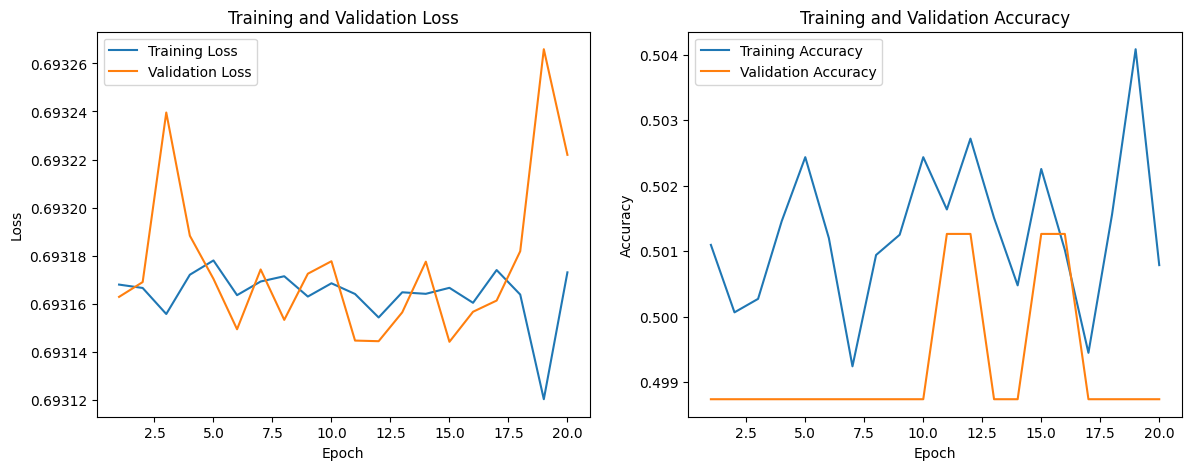

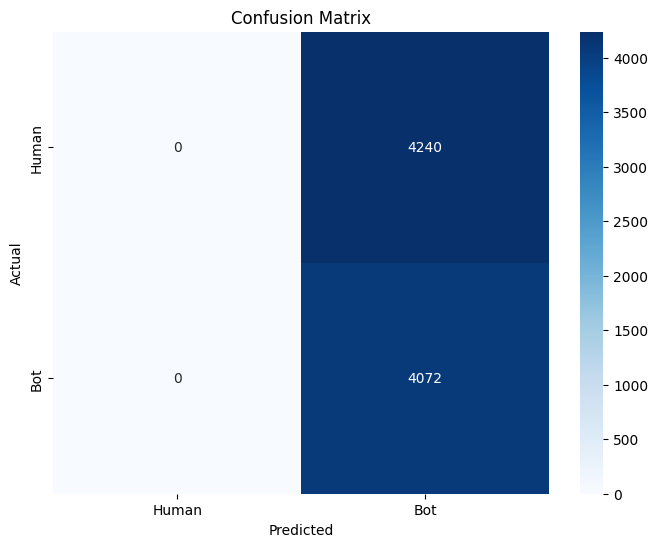

In [20]:
# Plotting training and validation losses
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
# plt.savefig('images/lstm-action-accuracy.png')
plt.show()

# Generate confusion matrix
def generate_confusion_matrix(dataloader, model):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for text_batch, label_batch, lengths in dataloader:
            preds = model(text_batch, lengths)[:, 0]
            all_preds.extend((preds >= 0.5).cpu().numpy())
            all_labels.extend(label_batch.cpu().numpy())

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Human', 'Bot'], yticklabels=['Human', 'Bot'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Generate confusion matrix on the test dataset
generate_confusion_matrix(test_dl, model)
